Image counts per class:
Clean: 1493
Dusty: 1069


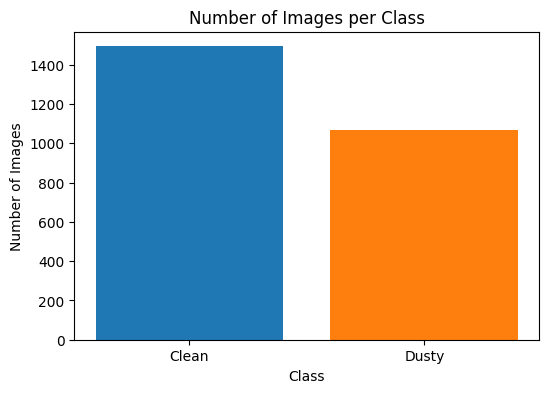

In [14]:
import os
import matplotlib.pyplot as plt

# Define the dataset path
dataset_path = './Detect_solar_dust'

# Define class folders
classes = ['Clean', 'Dusty']

# Count images
image_counts = {}
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    image_counts[cls] = len(image_files)

# Print counts
print("Image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")

# Assign colors (one per class)
colors = ['#1f77b4', '#ff7f0e']  # Clean → blue, Dusty → orange

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(image_counts.keys(), image_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()


Selected image counts per class:
Clean: 150
Dusty: 30


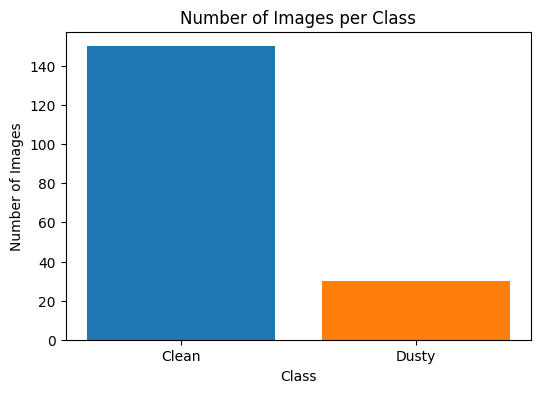

In [15]:
import os
import matplotlib.pyplot as plt

# Define the dataset path
dataset_path = './Detect_solar_dust'

# Define class folders
classes = ['Clean', 'Dusty']

# Initialize image count dictionary
image_counts = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if cls == 'Dusty':
        # Take 30 images from Dusty
        selected_files = image_files[:30]
        image_counts[cls] = len(selected_files)
    else:
        # Take 150 images from Clean
        selected_files = image_files[:150]
        image_counts[cls] = len(selected_files)

# Print counts
print("Selected image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")

# Assign colors (unique for each class)
colors = ['#1f77b4', '#ff7f0e']  # Clean → blue, Dusty → orange

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(image_counts.keys(), image_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
#plt.savefig('image_counts_per_class.png')
plt.show()

Final image counts per class:
Clean: 150
Dusty: 90


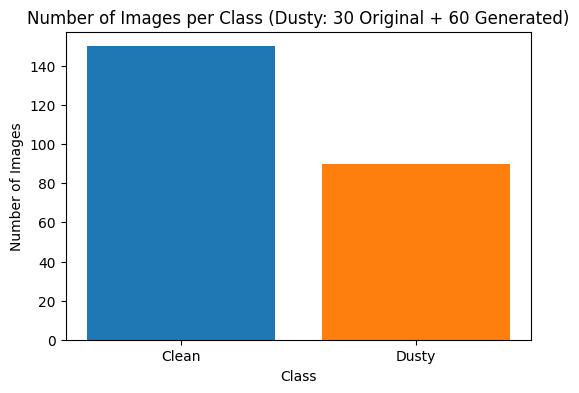

In [16]:
import os
import matplotlib.pyplot as plt

# Define the dataset paths
dataset_path = './Detect_solar_dust'
generated_path = r'D:\Raj Kumar\Hybrid Augmentation Approach\generated_solar_faults'

# Define class folders
classes = ['Clean', 'Dusty']

# Initialize image count dictionary
image_counts = {}

# Process Clean and Dusty classes
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if cls == 'Dusty':
        # Take 30 original Dusty images
        selected_dusty_files = image_files[:30]
                
        # Count 60 generated images
        generated_files = [f for f in os.listdir(generated_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        selected_generated_files = generated_files[:60]
        
        total_dusty = len(selected_dusty_files) + len(selected_generated_files)
        image_counts[cls] = total_dusty
    else:
        # Take 150 Clean images
        selected_clean_files = image_files[:150]
        image_counts[cls] = len(selected_clean_files)

# Print counts
print("Final image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")
    
# Assign colors (unique for each class)
colors = ['#1f77b4', '#ff7f0e']  # Clean → blue, Dusty → orange

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(image_counts.keys(), image_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Dusty: 30 Original + 60 Generated)')
#plt.savefig('image_counts_per_class.png')
plt.show()

#### Feature Extraction

In [17]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Paths
clean_path = './Detect_solar_dust/Clean'
dusty_path = './Detect_solar_dust/Dusty'
generated_path = r'D:\Raj Kumar\Hybrid Augmentation Approach\generated_solar_faults'

# Collect selected image paths
# 150 Clean images
clean_files = [os.path.join(clean_path, f) for f in os.listdir(clean_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:150]
# 30 original Dusty images
dusty_files = [os.path.join(dusty_path, f) for f in os.listdir(dusty_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:30]
# 60 generated images
generated_files = [os.path.join(generated_path, f) for f in os.listdir(generated_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:60]

# Combine Dusty and Generated files for Dusty category
dusty_all_files = dusty_files + generated_files

# Load pretrained DenseNet121
model = models.densenet121(weights='IMAGENET1K_V1')
model.eval()
model.to(device)

# Remove classifier, keep only feature extractor
feature_extractor = model.features

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Feature extraction function
def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = feature_extractor(img)
        features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)  # Flatten to (1, 1024)
    return features.cpu().numpy()

# Extract features for Clean images
clean_features_list = []
clean_file_names = []
for img_path in tqdm(clean_files, desc='Extracting features (Clean)'):
    features = extract_features(img_path)
    clean_features_list.append(features[0])
    clean_file_names.append(os.path.basename(img_path))

# Convert Clean features to numpy array → shape (150, 1024)
clean_features_array = np.array(clean_features_list)

# Save Clean features directly in current directory
np.save('CLEAN_FEATURES.npy', clean_features_array)
print("✅ Saved to CLEAN_FEATURES.npy with shape:", clean_features_array.shape)

# Save Clean features to .csv
clean_df = pd.DataFrame(clean_features_array)
clean_df.insert(0, 'filename', clean_file_names)
clean_df.insert(1, 'label', [0] * len(clean_files))  # Label: 0 for Clean
clean_df.to_csv('CLEAN_FEATURES.csv', index=False)
print("✅ Saved to CLEAN_FEATURES.csv with shape:", clean_df.shape)

# Extract features for Dusty images (original + generated)
dusty_features_list = []
dusty_file_names = []
for img_path in tqdm(dusty_all_files, desc='Extracting features (Dusty)'):
    features = extract_features(img_path)
    dusty_features_list.append(features[0])
    dusty_file_names.append(os.path.basename(img_path))

# Convert Dusty features to numpy array → shape (90, 1024)
dusty_features_array = np.array(dusty_features_list)

# Save Dusty features directly in current directory
np.save('DUSTY_FEATURES.npy', dusty_features_array)
print("✅ Saved to DUSTY_FEATURES.npy with shape:", dusty_features_array.shape)

# Save Dusty features to .csv
dusty_df = pd.DataFrame(dusty_features_array)
dusty_df.insert(0, 'filename', dusty_file_names)
dusty_df.insert(1, 'label', [1] * len(dusty_all_files))  # Label: 1 for Dusty/Generated
dusty_df.to_csv('DUSTY_FEATURES.csv', index=False)
print("✅ Saved to DUSTY_FEATURES.csv with shape:", dusty_df.shape)

🚀 Using device: cuda


Extracting features (Clean): 100%|██████████| 150/150 [00:19<00:00,  7.75it/s]


✅ Saved to CLEAN_FEATURES.npy with shape: (150, 1024)
✅ Saved to CLEAN_FEATURES.csv with shape: (150, 1026)


Extracting features (Dusty): 100%|██████████| 90/90 [00:07<00:00, 11.30it/s]

✅ Saved to DUSTY_FEATURES.npy with shape: (90, 1024)
✅ Saved to DUSTY_FEATURES.csv with shape: (90, 1026)


#### Applying SMOTE

In [18]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

# Load feature files from CSV (skip 'filename' column)
dusty_features = pd.read_csv('DUSTY_FEATURES.csv').drop(columns=['filename']).values
clean_features = pd.read_csv('CLEAN_FEATURES.csv').drop(columns=['filename']).values

# Combine features and create labels
X = np.vstack([dusty_features, clean_features])
y = np.array([0] * len(dusty_features) + [1] * len(clean_features))  # 0 = Dusty, 1 = Clean

print(f"Before SMOTE → Dusty: {sum(y==0)}, Clean: {sum(y==1)}")

# Determine target count to balance both classes
target_count = max(sum(y == 0), sum(y == 1))

# Apply SMOTE to balance both classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Calculate how many synthetic samples were added
num_dusty_generated = sum(y_resampled == 0) - sum(y == 0)
num_clean_generated = sum(y_resampled == 1) - sum(y == 1)

# Save synthetic samples separately
dusty_indices = np.where(y_resampled == 0)[0]
clean_indices = np.where(y_resampled == 1)[0]

synthetic_dusty = X_resampled[dusty_indices][len(dusty_features):]
synthetic_clean = X_resampled[clean_indices][len(clean_features):]

np.save('SYNTHETIC_DUSTY_FEATURES.npy', synthetic_dusty)
np.save('SYNTHETIC_CLEAN_FEATURES.npy', synthetic_clean)

# Final summary
final_dusty = sum(y_resampled == 0)
final_clean = sum(y_resampled == 1)

print("✅ SMOTE completed.")
print("Final Dusty samples:", final_dusty)
print("Final Clean samples:", final_clean)
print("Synthetic Dusty samples generated:", num_dusty_generated)
print("Synthetic Clean samples generated:", num_clean_generated)
print("Final dataset shape:", X_resampled.shape)

# Save full balanced dataset
np.save('X_balanced.npy', X_resampled)
np.save('y_balanced.npy', y_resampled)
pd.DataFrame(X_resampled).to_csv('X_balanced.csv', index=False)
pd.DataFrame(y_resampled, columns=['label']).to_csv('y_balanced.csv', index=False)
print("✅ Saved full balanced dataset as X_balanced.npy, y_balanced.npy, X_balanced.csv, y_balanced.csv")


Before SMOTE → Dusty: 90, Clean: 150
✅ SMOTE completed.
Final Dusty samples: 150
Final Clean samples: 150
Synthetic Dusty samples generated: 60
Synthetic Clean samples generated: 0
Final dataset shape: (300, 1025)
✅ Saved full balanced dataset as X_balanced.npy, y_balanced.npy, X_balanced.csv, y_balanced.csv


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load balanced labels
y_resampled = np.load('y_balanced.npy')

# Check counts
dusty_count = sum(y_resampled == 0)
clean_count = sum(y_resampled == 1)

print(f"✅ Dusty samples: {dusty_count}")
print(f"✅ Clean samples: {clean_count}")

# Check if balanced
if dusty_count == clean_count:
    print("✅ Dataset is perfectly balanced! 💥")
else:
    print("⚠️ Dataset is imbalanced.")


✅ Dusty samples: 150
✅ Clean samples: 150
✅ Dataset is perfectly balanced! 💥


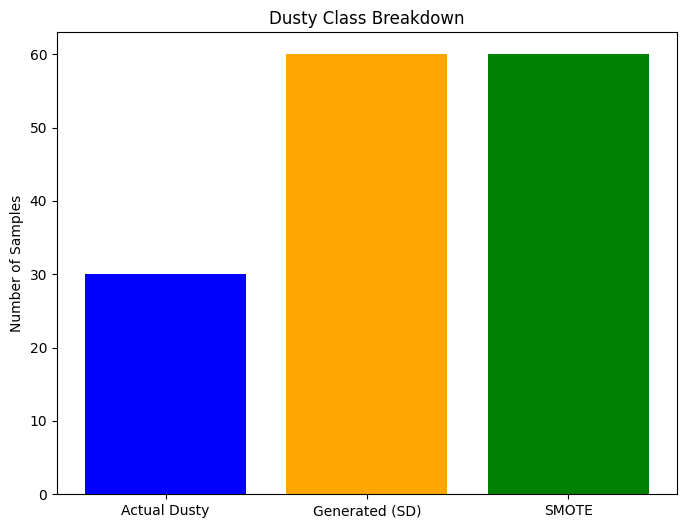

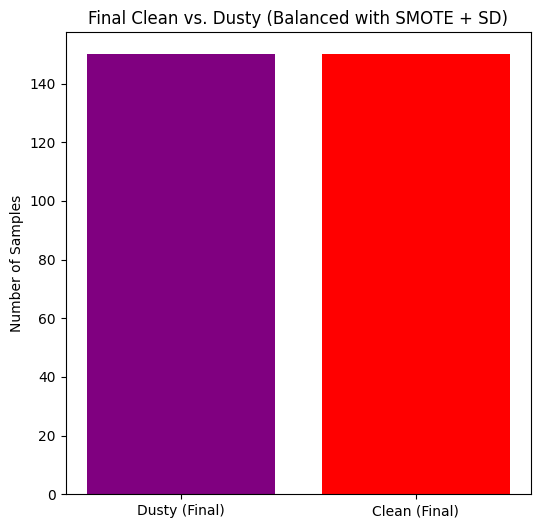

In [20]:
import matplotlib.pyplot as plt

# Actual, generated, SMOTE counts (set these manually or calculate)
actual_dusty = 30
generated_dusty = 60
smote_dusty = 60

# Final balanced dataset (load from y_balanced.npy if needed)
final_dusty = actual_dusty + generated_dusty + smote_dusty  # or get from np.sum(y_resampled == 0)
final_clean = final_dusty  # since you balanced to match

# Plot 1: Breakdown of Dusty samples
plt.figure(figsize=(8, 6))
plt.bar(['Actual Dusty', 'Generated (SD)', 'SMOTE'], [actual_dusty, generated_dusty, smote_dusty], color=['blue', 'orange', 'green'])
plt.ylabel('Number of Samples')
plt.title('Dusty Class Breakdown')
plt.show()

# Plot 2: Final Clean vs. Dusty balance
plt.figure(figsize=(6, 6))
plt.bar(['Dusty (Final)', 'Clean (Final)'], [final_dusty, final_clean], color=['purple', 'red'])
plt.ylabel('Number of Samples')
plt.title('Final Clean vs. Dusty (Balanced with SMOTE + SD)')
plt.show()


#### Reshaping and Balancing

In [21]:
# After SMOTE:
# X_resampled → features, shape (n_samples, 1024)
# y_resampled → labels, shape (n_samples, )

np.save('X_resampled.npy', X_resampled)
np.save('y_resampled.npy', y_resampled)

print("Saved resampled features and labels to disk.")


Saved resampled features and labels to disk.


Final class counts after SMOTE:
Dusty: 150
Clean: 150


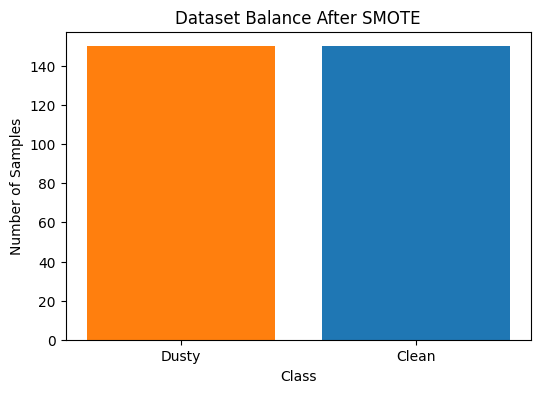

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved arrays
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Count samples per class
unique, counts = np.unique(y_resampled, return_counts=True)
class_counts = dict(zip(unique, counts))

# Print class counts
print("Final class counts after SMOTE:")
for cls, count in class_counts.items():
    label = 'Dusty' if cls == 0 else 'Clean'
    print(f"{label}: {count}")

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Dusty', 'Clean'], [class_counts.get(0, 0), class_counts.get(1, 0)], color=['#ff7f0e', '#1f77b4'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Dataset Balance After SMOTE')
plt.show()


#### Splitting Train and Test

In [23]:
from sklearn.model_selection import train_test_split

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


### TabNet

In [26]:
import numpy as np
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import joblib
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directory
#os.makedirs('saved_models', exist_ok=True)
os.makedirs('PLOTS_TabNet', exist_ok=True)  # Directory for saving plots

# Prepare 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-fold cross-validation with TabNet...")

# Lists to store validation accuracy curves for all folds
all_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    print(f"\n=== Fold {fold + 1} (TabNet) ===")

    # Initialize TabNet
    tabnet_model = TabNetClassifier(
        n_d=64,  # Width of decision prediction layer
        n_a=64,  # Width of attention embedding
        n_steps=5,  # Number of attention steps
        gamma=1.3,  # Scaling factor for attention updates
        lambda_sparse=1e-3,  # Sparsity regularization
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',  # Sparsemax for attention
        device_name=str(device)
    )

    # Train TabNet
    tabnet_model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'val'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=10,  # Early stopping
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Extract training history
    history = tabnet_model.history
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    # Store validation accuracy for combined plot
    all_val_accuracies.append(val_acc)

    # Plot accuracy per epoch for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_TabNet/accuracy_fold_{fold + 1}.png')
    plt.close()

    # Evaluate on validation data
    val_pred = tabnet_model.predict(X_val)
    val_acc_final = accuracy_score(y_val, val_pred)

    print(f"Fold {fold + 1} Best Validation Accuracy: {val_acc_final:.4f}")
    print("TabNet Classification Report:")
    print(classification_report(y_val, val_pred, target_names=['Clean', 'Dirty']))
    print("TabNet Confusion Matrix:")
    print(confusion_matrix(y_val, val_pred))

    # Plot feature importance
    feature_importances = tabnet_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.title(f'Fold {fold + 1} - Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.grid(True)
    plt.savefig(f'PLOTS_TabNet/feature_importance_fold_{fold + 1}.png')
    plt.close()

    # Save the model
    # model_path = f"saved_models/best_tabnet_fold_{fold + 1}.joblib"
    # joblib.dump(tabnet_model, model_path)
    # print(f"✅ Saved best TabNet model for Fold {fold + 1} to: {model_path}")

# Plot combined validation accuracy for all folds
plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for fold, val_acc in enumerate(all_val_accuracies):
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=f'Fold {fold + 1}', color=colors[fold])
plt.title('Validation Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_TabNet/combined_validation_accuracy.png')
plt.close()

print("✅ All plots saved in 'plots' directory")

🚀 Using device: cuda
Running 5-fold cross-validation with TabNet...

=== Fold 1 (TabNet) ===


c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21768 | train_accuracy: 0.48333 | val_accuracy: 0.5     |  0:00:00s
epoch 1  | loss: 1.41429 | train_accuracy: 0.53333 | val_accuracy: 0.61667 |  0:00:00s
epoch 2  | loss: 1.05707 | train_accuracy: 0.55417 | val_accuracy: 0.45    |  0:00:01s
epoch 3  | loss: 1.18987 | train_accuracy: 0.5125  | val_accuracy: 0.48333 |  0:00:01s
epoch 4  | loss: 1.03583 | train_accuracy: 0.52917 | val_accuracy: 0.46667 |  0:00:01s
epoch 5  | loss: 0.68112 | train_accuracy: 0.59583 | val_accuracy: 0.58333 |  0:00:01s
epoch 6  | loss: 0.77058 | train_accuracy: 0.65417 | val_accuracy: 0.56667 |  0:00:01s
epoch 7  | loss: 0.65074 | train_accuracy: 0.67917 | val_accuracy: 0.53333 |  0:00:02s
epoch 8  | loss: 0.64795 | train_accuracy: 0.6625  | val_accuracy: 0.58333 |  0:00:02s
epoch 9  | loss: 0.63716 | train_accuracy: 0.7125  | val_accuracy: 0.6     |  0:00:02s
epoch 10 | loss: 0.57329 | train_accuracy: 0.7375  | val_accuracy: 0.6     |  0:00:02s
epoch 11 | loss: 0.56229 | train_accuracy: 

c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 1 Best Validation Accuracy: 0.8833
TabNet Classification Report:
              precision    recall  f1-score   support

       Clean       0.96      0.80      0.87        30
       Dirty       0.83      0.97      0.89        30

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60

TabNet Confusion Matrix:
[[24  6]
 [ 1 29]]

=== Fold 2 (TabNet) ===


c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26802 | train_accuracy: 0.49583 | val_accuracy: 0.4     |  0:00:00s
epoch 1  | loss: 1.63978 | train_accuracy: 0.55833 | val_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.97015 | train_accuracy: 0.4875  | val_accuracy: 0.53333 |  0:00:00s
epoch 3  | loss: 1.16573 | train_accuracy: 0.5     | val_accuracy: 0.51667 |  0:00:00s
epoch 4  | loss: 1.07574 | train_accuracy: 0.58333 | val_accuracy: 0.66667 |  0:00:01s
epoch 5  | loss: 0.72916 | train_accuracy: 0.6     | val_accuracy: 0.58333 |  0:00:01s
epoch 6  | loss: 0.73539 | train_accuracy: 0.6     | val_accuracy: 0.65    |  0:00:01s
epoch 7  | loss: 0.79543 | train_accuracy: 0.60833 | val_accuracy: 0.6     |  0:00:01s
epoch 8  | loss: 0.6991  | train_accuracy: 0.62083 | val_accuracy: 0.48333 |  0:00:01s
epoch 9  | loss: 0.61492 | train_accuracy: 0.67083 | val_accuracy: 0.58333 |  0:00:02s
epoch 10 | loss: 0.62135 | train_accuracy: 0.675   | val_accuracy: 0.61667 |  0:00:02s
epoch 11 | loss: 0.61646 | train_accuracy: 

c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 2 Best Validation Accuracy: 0.8500
TabNet Classification Report:
              precision    recall  f1-score   support

       Clean       0.86      0.83      0.85        30
       Dirty       0.84      0.87      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

TabNet Confusion Matrix:
[[25  5]
 [ 4 26]]

=== Fold 3 (TabNet) ===


c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47189 | train_accuracy: 0.50417 | val_accuracy: 0.51667 |  0:00:00s
epoch 1  | loss: 1.44094 | train_accuracy: 0.5375  | val_accuracy: 0.48333 |  0:00:00s
epoch 2  | loss: 1.19931 | train_accuracy: 0.4875  | val_accuracy: 0.56667 |  0:00:00s
epoch 3  | loss: 1.18483 | train_accuracy: 0.59583 | val_accuracy: 0.58333 |  0:00:00s
epoch 4  | loss: 1.09694 | train_accuracy: 0.59167 | val_accuracy: 0.55    |  0:00:01s
epoch 5  | loss: 0.9523  | train_accuracy: 0.58333 | val_accuracy: 0.53333 |  0:00:01s
epoch 6  | loss: 0.68326 | train_accuracy: 0.59167 | val_accuracy: 0.53333 |  0:00:01s
epoch 7  | loss: 0.7549  | train_accuracy: 0.65833 | val_accuracy: 0.53333 |  0:00:01s
epoch 8  | loss: 0.63184 | train_accuracy: 0.68333 | val_accuracy: 0.51667 |  0:00:01s
epoch 9  | loss: 0.65188 | train_accuracy: 0.68333 | val_accuracy: 0.5     |  0:00:01s
epoch 10 | loss: 0.76241 | train_accuracy: 0.6875  | val_accuracy: 0.58333 |  0:00:02s
epoch 11 | loss: 0.55323 | train_accuracy: 

c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 3 Best Validation Accuracy: 0.9500
TabNet Classification Report:
              precision    recall  f1-score   support

       Clean       0.97      0.93      0.95        30
       Dirty       0.94      0.97      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

TabNet Confusion Matrix:
[[28  2]
 [ 1 29]]

=== Fold 4 (TabNet) ===


c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23983 | train_accuracy: 0.46667 | val_accuracy: 0.4     |  0:00:00s
epoch 1  | loss: 1.28311 | train_accuracy: 0.5     | val_accuracy: 0.48333 |  0:00:00s
epoch 2  | loss: 1.15743 | train_accuracy: 0.52083 | val_accuracy: 0.51667 |  0:00:00s
epoch 3  | loss: 1.02248 | train_accuracy: 0.5375  | val_accuracy: 0.55    |  0:00:00s
epoch 4  | loss: 0.9849  | train_accuracy: 0.52917 | val_accuracy: 0.53333 |  0:00:01s
epoch 5  | loss: 1.04068 | train_accuracy: 0.5625  | val_accuracy: 0.5     |  0:00:01s
epoch 6  | loss: 0.78155 | train_accuracy: 0.58333 | val_accuracy: 0.53333 |  0:00:01s
epoch 7  | loss: 0.82032 | train_accuracy: 0.59167 | val_accuracy: 0.48333 |  0:00:01s
epoch 8  | loss: 0.64754 | train_accuracy: 0.65    | val_accuracy: 0.46667 |  0:00:01s
epoch 9  | loss: 0.62641 | train_accuracy: 0.65    | val_accuracy: 0.61667 |  0:00:02s
epoch 10 | loss: 0.63878 | train_accuracy: 0.7     | val_accuracy: 0.63333 |  0:00:02s
epoch 11 | loss: 0.67168 | train_accuracy: 

c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 4 Best Validation Accuracy: 0.7667
TabNet Classification Report:
              precision    recall  f1-score   support

       Clean       0.74      0.83      0.78        30
       Dirty       0.81      0.70      0.75        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60

TabNet Confusion Matrix:
[[25  5]
 [ 9 21]]

=== Fold 5 (TabNet) ===


c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32091 | train_accuracy: 0.475   | val_accuracy: 0.41667 |  0:00:00s
epoch 1  | loss: 1.41698 | train_accuracy: 0.49583 | val_accuracy: 0.56667 |  0:00:00s
epoch 2  | loss: 1.15508 | train_accuracy: 0.55417 | val_accuracy: 0.53333 |  0:00:00s
epoch 3  | loss: 1.19257 | train_accuracy: 0.60833 | val_accuracy: 0.6     |  0:00:00s
epoch 4  | loss: 0.86906 | train_accuracy: 0.6125  | val_accuracy: 0.65    |  0:00:01s
epoch 5  | loss: 0.90439 | train_accuracy: 0.6375  | val_accuracy: 0.63333 |  0:00:01s
epoch 6  | loss: 0.72653 | train_accuracy: 0.64583 | val_accuracy: 0.61667 |  0:00:01s
epoch 7  | loss: 0.75137 | train_accuracy: 0.675   | val_accuracy: 0.66667 |  0:00:01s
epoch 8  | loss: 0.67979 | train_accuracy: 0.72083 | val_accuracy: 0.68333 |  0:00:01s
epoch 9  | loss: 0.577   | train_accuracy: 0.69167 | val_accuracy: 0.68333 |  0:00:02s
epoch 10 | loss: 0.60418 | train_accuracy: 0.71667 | val_accuracy: 0.68333 |  0:00:02s
epoch 11 | loss: 0.56015 | train_accuracy: 

c:\Users\USER\anaconda3\envs\kinzaenv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 5 Best Validation Accuracy: 1.0000
TabNet Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00        30
       Dirty       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

TabNet Confusion Matrix:
[[30  0]
 [ 0 30]]
✅ All plots saved in 'plots' directory


### ResNet50

In [27]:
# Install dependencies: pip install numpy pandas scikit-learn matplotlib joblib tqdm torch torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from tqdm import tqdm
from itertools import product

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Define custom ResNet-50 classifier for pre-extracted features
class ResNetClassifier(nn.Module):
    def __init__(self, hidden_dim=1024, num_classes=2, hidden_size=256, dropout=0.1):
        super(ResNetClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

# Load features and labels
X_resampled = np.load('X_resampled.npy')  # Shape: (3000, 1024) for features
y_resampled = np.load('y_resampled.npy')  # Shape: (3000,) with 0=Clean, 1=Dirty

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_ResNet', exist_ok=True)
os.makedirs('PLOTS_ResNet', exist_ok=True)

# 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_train_acc = []
all_val_acc = []

# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'batch_size': [32, 64],
    'dropout': [0.1, 0.2],
    'class_weight': [1.0, 1.5]  # Weight for Dirty class
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled, y_resampled)):
    print(f"\n=== Fold {fold + 1} ===")
    
    best_val_acc = 0
    best_model_state = None
    best_val_preds = None
    best_train_acc_per_epoch = []
    best_val_acc_per_epoch = []
    best_params = None
    
    # Hyperparameter tuning
    for lr, bs, dropout, weight in product(param_grid['learning_rate'], param_grid['batch_size'], param_grid['dropout'], param_grid['class_weight']):
        print(f"Training with lr={lr}, batch_size={bs}, dropout={dropout}, class_weight={weight}")
        
        # Prepare data
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs)
        
        # Initialize model, loss, optimizer, and scheduler
        model = ResNetClassifier(hidden_dim=1024, num_classes=2, hidden_size=256, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, weight]).to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        # Training loop with early stopping
        no_improve_count = 0
        train_acc_per_epoch = []
        val_acc_per_epoch = []
        patience = 20
        
        for epoch in tqdm(range(100), desc=f'Fold {fold + 1} lr={lr} bs={bs} drop={dropout} weight={weight}'):
            # Training
            model.train()
            train_correct = 0
            train_total = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_total += y_batch.size(0)
                train_correct += (predicted == y_batch).sum().item()
            train_acc = train_correct / train_total
            train_acc_per_epoch.append(train_acc)
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_preds = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    val_total += y_batch.size(0)
                    val_correct += (predicted == y_batch).sum().item()
                    val_preds.extend(predicted.cpu().numpy())
            val_acc = val_correct / val_total
            val_acc_per_epoch.append(val_acc)
            
            # Scheduler step
            scheduler.step(val_acc)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                best_val_preds = val_preds
                best_train_acc_per_epoch = train_acc_per_epoch.copy()
                best_val_acc_per_epoch = val_acc_per_epoch.copy()
                best_params = {'lr': lr, 'batch_size': bs, 'dropout': dropout, 'class_weight': weight}
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch + 1} with params {best_params}")
                break
        
        print(f"Params lr={lr}, bs={bs}, drop={dropout}, weight={weight}: Best Val Acc = {best_val_acc:.4f}")
    
    # Store fold accuracy
    fold_accuracies.append(best_val_acc)
    all_train_acc.append(best_train_acc_per_epoch)
    all_val_acc.append(best_val_acc_per_epoch)
    
    # Plot training and validation accuracy for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_train_acc_per_epoch) + 1), best_train_acc_per_epoch, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(best_val_acc_per_epoch) + 1), best_val_acc_per_epoch, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - ResNet Accuracy (Params: {best_params})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_ResNet/resnet_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_ResNet/resnet_accuracy_fold_{fold + 1}.png")
    
    # Classification report and confusion matrix
    print(f"\nFold {fold + 1} Validation Accuracy: {best_val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, best_val_preds, target_names=['Clean', 'Dirty']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_preds))
    
    # Save the best model
    #model_path = f"saved_models_ResNet/resnet_fold_{fold + 1}.pt"
    #torch.save(best_model_state, model_path)
    #print(f"Fold {fold + 1}: Saved ResNet model to {model_path}")

# Combined validation accuracy plot for all folds (only validation accuracy)
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for fold in range(5):
    plt.plot(range(1, len(all_val_acc[fold]) + 1), all_val_acc[fold], 
             label=f'Fold {fold + 1} Val', color=colors[fold], linestyle='-')
plt.title('ResNet Validation Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_ResNet/resnet_combined_accuracy.png')
plt.close()
print("Saved combined validation accuracy plot to plots_ResNet/resnet_combined_accuracy.png")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy (across all folds): {final_best_accuracy:.4f}")

🚀 Using device: cuda

=== Fold 1 ===
Training with lr=0.001, batch_size=32, dropout=0.1, class_weight=1.0


Fold 1 lr=0.001 bs=32 drop=0.1 weight=1.0:   0%|          | 0/100 [00:00<?, ?it/s]

Fold 1 lr=0.001 bs=32 drop=0.1 weight=1.0:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1025 and 1024x256)

### ViT

In [ ]:
# Install dependencies: pip install numpy pandas scikit-learn matplotlib joblib tqdm torch transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from tqdm import tqdm
from itertools import product

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Define custom ViT classification head for pre-extracted features
class ViTClassifier(nn.Module):
    def __init__(self, hidden_dim=1024, num_classes=2, hidden_size=256, dropout=0.1):
        super(ViTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

# Load features and labels
X_resampled = np.load('X_resampled.npy')  # Shape: (3000, 1024) for ViT features
y_resampled = np.load('y_resampled.npy')  # Shape: (3000,) with 0=Clean, 1=Dirty

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_ViT', exist_ok=True)
os.makedirs('PLOTS_ViT', exist_ok=True)

# 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_train_acc = []
all_val_acc = []

# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'batch_size': [32, 64],
    'dropout': [0.1, 0.2],
    'class_weight': [1.0, 1.5]  # Weight for Dirty class
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled, y_resampled)):
    print(f"\n=== Fold {fold + 1} ===")
    
    best_val_acc = 0
    best_model_state = None
    best_val_preds = None
    best_train_acc_per_epoch = []
    best_val_acc_per_epoch = []
    best_params = None
    
    # Hyperparameter tuning
    for lr, bs, dropout, weight in product(param_grid['learning_rate'], param_grid['batch_size'], param_grid['dropout'], param_grid['class_weight']):
        print(f"Training with lr={lr}, batch_size={bs}, dropout={dropout}, class_weight={weight}")
        
        # Prepare data
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs)
        
        # Initialize model, loss, optimizer, and scheduler
        model = ViTClassifier(hidden_dim=1024, num_classes=2, hidden_size=256, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, weight]).to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        # Training loop with early stopping
        no_improve_count = 0
        train_acc_per_epoch = []
        val_acc_per_epoch = []
        patience = 20
        
        for epoch in tqdm(range(100), desc=f'Fold {fold + 1} lr={lr} bs={bs} drop={dropout} weight={weight}'):
            # Training
            model.train()
            train_correct = 0
            train_total = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_total += y_batch.size(0)
                train_correct += (predicted == y_batch).sum().item()
            train_acc = train_correct / train_total
            train_acc_per_epoch.append(train_acc)
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_preds = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    val_total += y_batch.size(0)
                    val_correct += (predicted == y_batch).sum().item()
                    val_preds.extend(predicted.cpu().numpy())
            val_acc = val_correct / val_total
            val_acc_per_epoch.append(val_acc)
            
            # Scheduler step
            scheduler.step(val_acc)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                best_val_preds = val_preds
                best_train_acc_per_epoch = train_acc_per_epoch.copy()
                best_val_acc_per_epoch = val_acc_per_epoch.copy()
                best_params = {'lr': lr, 'batch_size': bs, 'dropout': dropout, 'class_weight': weight}
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch + 1} with params {best_params}")
                break
        
        print(f"Params lr={lr}, bs={bs}, drop={dropout}, weight={weight}: Best Val Acc = {best_val_acc:.4f}")
    
    # Store fold accuracy
    fold_accuracies.append(best_val_acc)
    all_train_acc.append(best_train_acc_per_epoch)
    all_val_acc.append(best_val_acc_per_epoch)
    
    # Plot training and validation accuracy for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_train_acc_per_epoch) + 1), best_train_acc_per_epoch, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(best_val_acc_per_epoch) + 1), best_val_acc_per_epoch, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - ViT Accuracy over Epochs (Params: {best_params})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_ViT/vit_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_ViT/vit_accuracy_fold_{fold + 1}.png")
    
    # Classification report and confusion matrix
    print(f"\nFold {fold + 1} Validation Accuracy: {best_val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, best_val_preds, target_names=['Clean', 'Dirty']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_preds))
    
    # Save the best model
    #model_path = f"saved_models_ViT/vit_fold_{fold + 1}.pt"
    #torch.save(best_model_state, model_path)
    #print(f"Fold {fold + 1}: Saved ViT model to {model_path}")

# Combined validation accuracy plot for all folds (only validation accuracy)
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for fold in range(5):
    plt.plot(range(1, len(all_val_acc[fold]) + 1), all_val_acc[fold], 
             label=f'Fold {fold + 1} Val', color=colors[fold], linestyle='-')
plt.title('ViT Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_ViT/vit_combined_accuracy.png')
plt.close()
print("Saved combined validation accuracy plot to plots_ViT/vit_combined_accuracy.png")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy (across all folds): {final_best_accuracy:.4f}")

🚀 Using device: cuda

=== Fold 1 ===
Training with lr=0.001, batch_size=32, dropout=0.1, class_weight=1.0


Fold 1 lr=0.001 bs=32 drop=0.1 weight=1.0:  45%|████▌     | 45/100 [00:09<00:12,  4.56it/s]


Early stopping at epoch 46 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1, 'class_weight': 1.0}
Params lr=0.001, bs=32, drop=0.1, weight=1.0: Best Val Acc = 0.9281
Training with lr=0.001, batch_size=32, dropout=0.1, class_weight=1.5


Fold 1 lr=0.001 bs=32 drop=0.1 weight=1.5:  19%|█▉        | 19/100 [00:04<00:18,  4.46it/s]


Early stopping at epoch 20 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1, 'class_weight': 1.0}
Params lr=0.001, bs=32, drop=0.1, weight=1.5: Best Val Acc = 0.9281
Training with lr=0.001, batch_size=32, dropout=0.2, class_weight=1.0


Fold 1 lr=0.001 bs=32 drop=0.2 weight=1.0:  19%|█▉        | 19/100 [00:03<00:16,  4.78it/s]


Early stopping at epoch 20 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1, 'class_weight': 1.0}
Params lr=0.001, bs=32, drop=0.2, weight=1.0: Best Val Acc = 0.9281
Training with lr=0.001, batch_size=32, dropout=0.2, class_weight=1.5


Fold 1 lr=0.001 bs=32 drop=0.2 weight=1.5:  19%|█▉        | 19/100 [00:04<00:17,  4.73it/s]


Early stopping at epoch 20 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1, 'class_weight': 1.0}
Params lr=0.001, bs=32, drop=0.2, weight=1.5: Best Val Acc = 0.9281
Training with lr=0.001, batch_size=64, dropout=0.1, class_weight=1.0


Fold 1 lr=0.001 bs=64 drop=0.1 weight=1.0:  11%|█         | 11/100 [00:01<00:10,  8.52it/s]


KeyboardInterrupt: 

### ViT - Head (ViT-Head 1) - Best Accuracy Model

In [ ]:
# Install dependencies: pip install numpy pandas scikit-learn matplotlib joblib tqdm torch transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Define ViT classification head
class ViTHead(nn.Module):
    def __init__(self, hidden_dim=1024, num_classes=2):
        super(ViTHead, self).__init__()
        self.head = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        return self.head(x)

# Load features and labels
X_resampled = np.load('X_resampled.npy')  # Shape: (3000, 1024) for ViT features
y_resampled = np.load('y_resampled.npy')  # Shape: (3000,) with 0=Clean, 1=Dirty

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_ViTHead_1', exist_ok=True)
os.makedirs('PLOTS_ViTHead_1', exist_ok=True)

# 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_train_acc = []
all_val_acc = []

# Training parameters
batch_size = 64
max_epochs = 100
patience = 20
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled, y_resampled)):
    print(f"\n=== Fold {fold + 1} ===")
    
    # Prepare data
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss, and optimizer
    model = ViTHead(hidden_dim=1024, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop with early stopping
    best_val_acc = 0
    no_improve_count = 0
    train_acc_per_epoch = []
    val_acc_per_epoch = []
    
    for epoch in tqdm(range(max_epochs), desc=f'Fold {fold + 1}'):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        train_acc = train_correct / train_total
        train_acc_per_epoch.append(train_acc)
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_preds = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
                val_preds.extend(predicted.cpu().numpy())
        val_acc = val_correct / val_total
        val_acc_per_epoch.append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            best_val_preds = val_preds
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    # Store fold accuracy
    fold_accuracies.append(best_val_acc)
    all_train_acc.append(train_acc_per_epoch)
    all_val_acc.append(val_acc_per_epoch)
    
    # Plot training and validation accuracy for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_acc_per_epoch) + 1), train_acc_per_epoch, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(val_acc_per_epoch) + 1), val_acc_per_epoch, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - ViTHead Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_ViTHead_1/vithead_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_{fold + 1}.png")
    
    # Classification report and confusion matrix
    print(f"\nFold {fold + 1} Validation Accuracy: {best_val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, best_val_preds, target_names=['Clean', 'Dirty']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_preds))
    
    # Save the best model
    #model_path = f"saved_models_ViTHead_1/vithead_fold_{fold + 1}.pt"
    #torch.save(best_model_state, model_path)
    #print(f"Fold {fold + 1}: Saved ViTHead model to {model_path}")

# Combined accuracy plot for all folds
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for fold in range(5):
    plt.plot(range(1, len(all_train_acc[fold]) + 1), all_train_acc[fold], 
             label=f'Fold {fold + 1} Train', color=colors[fold], linestyle='--')
    plt.plot(range(1, len(all_val_acc[fold]) + 1), all_val_acc[fold], 
             label=f'Fold {fold + 1} Val', color=colors[fold], linestyle='-')
plt.title('ViTHead Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_ViTHead_1/vithead_combined_accuracy.png')
plt.close()
print("Saved combined accuracy plot to plots_ViTHead_1/vithead_combined_accuracy.png")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy (across all folds): {final_best_accuracy:.4f}")

🚀 Using device: cuda

=== Fold 1 ===


Fold 1:  27%|██▋       | 27/100 [00:01<00:04, 16.75it/s]


Early stopping at epoch 28
Fold 1: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_1.png

Fold 1 Validation Accuracy: 0.8997
Classification Report:
              precision    recall  f1-score   support

       Clean       0.89      0.91      0.90       299
       Dirty       0.91      0.89      0.90       299

    accuracy                           0.90       598
   macro avg       0.90      0.90      0.90       598
weighted avg       0.90      0.90      0.90       598

Confusion Matrix:
[[271  28]
 [ 32 267]]

=== Fold 2 ===


Fold 2:  14%|█▍        | 14/100 [00:00<00:05, 14.96it/s]


Early stopping at epoch 15
Fold 2: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_2.png

Fold 2 Validation Accuracy: 0.8727
Classification Report:
              precision    recall  f1-score   support

       Clean       0.87      0.87      0.87       299
       Dirty       0.87      0.87      0.87       298

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

Confusion Matrix:
[[261  38]
 [ 38 260]]

=== Fold 3 ===


Fold 3:  27%|██▋       | 27/100 [00:01<00:04, 17.42it/s]


Early stopping at epoch 28
Fold 3: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_3.png

Fold 3 Validation Accuracy: 0.8894
Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.86      0.89       299
       Dirty       0.87      0.92      0.89       298

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

Confusion Matrix:
[[258  41]
 [ 25 273]]

=== Fold 4 ===


Fold 4:  30%|███       | 30/100 [00:01<00:03, 19.66it/s]


Early stopping at epoch 31
Fold 4: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_4.png

Fold 4 Validation Accuracy: 0.8894
Classification Report:
              precision    recall  f1-score   support

       Clean       0.89      0.88      0.89       298
       Dirty       0.88      0.90      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

Confusion Matrix:
[[263  35]
 [ 31 268]]

=== Fold 5 ===


Fold 5:  17%|█▋        | 17/100 [00:00<00:04, 17.63it/s]


Early stopping at epoch 18
Fold 5: Saved accuracy plot to plots_ViTHead_1/vithead_accuracy_fold_5.png

Fold 5 Validation Accuracy: 0.8878
Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.86      0.88       298
       Dirty       0.87      0.91      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

Confusion Matrix:
[[257  41]
 [ 26 273]]
Saved combined accuracy plot to plots_ViTHead_1/vithead_combined_accuracy.png

Final Best Accuracy (across all folds): 0.8997


### Combine ViT head with MLP/SVM for a ~1–2% boost (ViT-Head 2)

In [ ]:
# Install dependencies: pip install numpy pandas scikit-learn matplotlib joblib tqdm torch transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from tqdm import tqdm
from itertools import product

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Define ViT classification head with deeper MLP
class ViTHead(nn.Module):
    def __init__(self, hidden_dim=1024, num_classes=2, hidden_size=256, dropout=0.1):
        super(ViTHead, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

# Load features and labels
X_resampled = np.load('X_resampled.npy')  # Shape: (3000, 1024) for ViT features
y_resampled = np.load('y_resampled.npy')  # Shape: (3000,) with 0=Clean, 1=Dirty

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_ViTHead', exist_ok=True)
os.makedirs('PLOTS_ViTHead_SVM&MLP', exist_ok=True)

# 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_train_acc = []
all_val_acc = []

# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'batch_size': [32, 64],
    'dropout': [0.1, 0.2]
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled, y_resampled)):
    print(f"\n=== Fold {fold + 1} ===")
    
    best_val_acc = 0
    best_model_state = None
    best_val_preds = None
    best_train_acc_per_epoch = []
    best_val_acc_per_epoch = []
    best_params = None
    
    # Hyperparameter tuning
    for lr, bs, dropout in product(param_grid['learning_rate'], param_grid['batch_size'], param_grid['dropout']):
        print(f"Training with lr={lr}, batch_size={bs}, dropout={dropout}")
        
        # Prepare data
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Oversample Dirty class (optional, enable if Dirty F1-score < 0.95)
        # dirty_idx = np.where(y_train == 1)[0]
        # oversample_idx = np.random.choice(dirty_idx, size=len(dirty_idx), replace=True)
        # X_train = np.vstack((X_train, X_train[oversample_idx]))
        # y_train = np.hstack((y_train, y_train[oversample_idx]))
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs)
        
        # Initialize model, loss, optimizer, and scheduler
        model = ViTHead(hidden_dim=1024, num_classes=2, hidden_size=256, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        # Training loop with early stopping
        no_improve_count = 0
        train_acc_per_epoch = []
        val_acc_per_epoch = []
        patience = 20
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        for epoch in tqdm(range(100), desc=f'Fold {fold + 1} lr={lr} bs={bs} drop={dropout}'):
            # Training
            model.train()
            train_correct = 0
            train_total = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_total += y_batch.size(0)
                train_correct += (predicted == y_batch).sum().item()
            train_acc = train_correct / train_total
            train_acc_per_epoch.append(train_acc)
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_preds = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    val_total += y_batch.size(0)
                    val_correct += (predicted == y_batch).sum().item()
                    val_preds.extend(predicted.cpu().numpy())
            val_acc = val_correct / val_total
            val_acc_per_epoch.append(val_acc)
            
            # Scheduler step
            scheduler.step(val_acc)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                best_val_preds = val_preds
                best_train_acc_per_epoch = train_acc_per_epoch.copy()
                best_val_acc_per_epoch = val_acc_per_epoch.copy()
                best_params = {'lr': lr, 'batch_size': bs, 'dropout': dropout}
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch + 1} with params {best_params}")
                break
        
        print(f"Params lr={lr}, bs={bs}, drop={dropout}: Best Val Acc = {best_val_acc:.4f}")
    
    # Store fold accuracy
    fold_accuracies.append(best_val_acc)
    all_train_acc.append(best_train_acc_per_epoch)
    all_val_acc.append(best_val_acc_per_epoch)
    
    # Plot training and validation accuracy for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_train_acc_per_epoch) + 1), best_train_acc_per_epoch, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(best_val_acc_per_epoch) + 1), best_val_acc_per_epoch, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - ViTHead Accuracy (Params: {best_params})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_ViTHead_SVM&MLP/vithead_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_{fold + 1}.png")
    
    # Classification report and confusion matrix
    print(f"\nFold {fold + 1} Validation Accuracy: {best_val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, best_val_preds, target_names=['Clean', 'Dirty']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_preds))
    
    # Save the best model
    #model_path = f"saved_models_ViTHead/vithead_fold_{fold + 1}.pt"
    #torch.save(best_model_state, model_path)
    #print(f"Fold {fold + 1}: Saved ViTHead model to {model_path}")

# Combined accuracy plot for all folds
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for fold in range(5):
    plt.plot(range(1, len(all_train_acc[fold]) + 1), all_train_acc[fold], 
             label=f'Fold {fold + 1} Train', color=colors[fold], linestyle='--')
    plt.plot(range(1, len(all_val_acc[fold]) + 1), all_val_acc[fold], 
             label=f'Fold {fold + 1} Val', color=colors[fold], linestyle='-')
plt.title('ViTHead Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_ViTHead_SVM&MLP/vithead_combined_accuracy.png')
plt.close()
print("Saved combined accuracy plot to plots_ViTHead/vithead_combined_accuracy.png")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy (across all folds): {final_best_accuracy:.4f}")


=== Fold 1 ===
Training with lr=0.001, batch_size=32, dropout=0.1


Fold 1 lr=0.001 bs=32 drop=0.1:  31%|███       | 31/100 [00:03<00:08,  7.84it/s]


Early stopping at epoch 32 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.1: Best Val Acc = 0.9247
Training with lr=0.001, batch_size=32, dropout=0.2


Fold 1 lr=0.001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:01<00:09,  8.78it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.2: Best Val Acc = 0.9247
Training with lr=0.001, batch_size=64, dropout=0.1


Fold 1 lr=0.001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:01<00:07, 11.13it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.1: Best Val Acc = 0.9247
Training with lr=0.001, batch_size=64, dropout=0.2


Fold 1 lr=0.001 bs=64 drop=0.2:  25%|██▌       | 25/100 [00:03<00:11,  6.41it/s]


Early stopping at epoch 26 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.001, bs=64, drop=0.2: Best Val Acc = 0.9298
Training with lr=0.0005, batch_size=32, dropout=0.1


Fold 1 lr=0.0005 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  3.95it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.1: Best Val Acc = 0.9298
Training with lr=0.0005, batch_size=32, dropout=0.2


Fold 1 lr=0.0005 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:21,  3.91it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.2: Best Val Acc = 0.9298
Training with lr=0.0005, batch_size=64, dropout=0.1


Fold 1 lr=0.0005 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:14,  5.96it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=64, drop=0.1: Best Val Acc = 0.9298
Training with lr=0.0005, batch_size=64, dropout=0.2


Fold 1 lr=0.0005 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:01<00:12,  7.08it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=64, drop=0.2: Best Val Acc = 0.9298
Training with lr=0.0001, batch_size=32, dropout=0.1


Fold 1 lr=0.0001 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:20,  4.18it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=32, drop=0.1: Best Val Acc = 0.9298
Training with lr=0.0001, batch_size=32, dropout=0.2


Fold 1 lr=0.0001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:21,  3.96it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=32, drop=0.2: Best Val Acc = 0.9298
Training with lr=0.0001, batch_size=64, dropout=0.1


Fold 1 lr=0.0001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.29it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=64, drop=0.1: Best Val Acc = 0.9298
Training with lr=0.0001, batch_size=64, dropout=0.2


Fold 1 lr=0.0001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:13,  6.27it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=64, drop=0.2: Best Val Acc = 0.9298
Fold 1: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_1.png

Fold 1 Validation Accuracy: 0.9298
Classification Report:
              precision    recall  f1-score   support

       Clean       0.93      0.93      0.93       299
       Dirty       0.93      0.93      0.93       299

    accuracy                           0.93       598
   macro avg       0.93      0.93      0.93       598
weighted avg       0.93      0.93      0.93       598

Confusion Matrix:
[[278  21]
 [ 21 278]]

=== Fold 2 ===
Training with lr=0.001, batch_size=32, dropout=0.1


Fold 2 lr=0.001 bs=32 drop=0.1:  17%|█▋        | 17/100 [00:04<00:20,  4.03it/s]


Early stopping at epoch 18 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.1: Best Val Acc = 0.8894
Training with lr=0.001, batch_size=32, dropout=0.2


Fold 2 lr=0.001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:23,  3.70it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.2: Best Val Acc = 0.8894
Training with lr=0.001, batch_size=64, dropout=0.1


Fold 2 lr=0.001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:14,  5.97it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.1: Best Val Acc = 0.8894
Training with lr=0.001, batch_size=64, dropout=0.2


Fold 2 lr=0.001 bs=64 drop=0.2:  29%|██▉       | 29/100 [00:04<00:10,  6.92it/s]


Early stopping at epoch 30 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.001, bs=64, drop=0.2: Best Val Acc = 0.8911
Training with lr=0.0005, batch_size=32, dropout=0.1


Fold 2 lr=0.0005 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  4.07it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.1: Best Val Acc = 0.8911
Training with lr=0.0005, batch_size=32, dropout=0.2


Fold 2 lr=0.0005 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:22,  3.77it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.2: Best Val Acc = 0.8911
Training with lr=0.0005, batch_size=64, dropout=0.1


Fold 2 lr=0.0005 bs=64 drop=0.1:  21%|██        | 21/100 [00:03<00:13,  5.97it/s]


Early stopping at epoch 22 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.1: Best Val Acc = 0.8961
Training with lr=0.0005, batch_size=64, dropout=0.2


Fold 2 lr=0.0005 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:14,  5.96it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.2: Best Val Acc = 0.8961
Training with lr=0.0001, batch_size=32, dropout=0.1


Fold 2 lr=0.0001 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  3.93it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.1: Best Val Acc = 0.8961
Training with lr=0.0001, batch_size=32, dropout=0.2


Fold 2 lr=0.0001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:23,  3.68it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.2: Best Val Acc = 0.8961
Training with lr=0.0001, batch_size=64, dropout=0.1


Fold 2 lr=0.0001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.37it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.1: Best Val Acc = 0.8961
Training with lr=0.0001, batch_size=64, dropout=0.2


Fold 2 lr=0.0001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:13,  6.15it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.2: Best Val Acc = 0.8961
Fold 2: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_2.png

Fold 2 Validation Accuracy: 0.8961
Classification Report:
              precision    recall  f1-score   support

       Clean       0.90      0.89      0.90       299
       Dirty       0.89      0.90      0.90       298

    accuracy                           0.90       597
   macro avg       0.90      0.90      0.90       597
weighted avg       0.90      0.90      0.90       597

Confusion Matrix:
[[266  33]
 [ 29 269]]

=== Fold 3 ===
Training with lr=0.001, batch_size=32, dropout=0.1


Fold 3 lr=0.001 bs=32 drop=0.1:  26%|██▌       | 26/100 [00:06<00:18,  3.92it/s]


Early stopping at epoch 27 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.001, batch_size=32, dropout=0.2


Fold 3 lr=0.001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:23,  3.71it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.2: Best Val Acc = 0.9112
Training with lr=0.001, batch_size=64, dropout=0.1


Fold 3 lr=0.001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.33it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.001, batch_size=64, dropout=0.2


Fold 3 lr=0.001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:14,  5.87it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.2: Best Val Acc = 0.9112
Training with lr=0.0005, batch_size=32, dropout=0.1


Fold 3 lr=0.0005 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  4.07it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0005, bs=32, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.0005, batch_size=32, dropout=0.2


Fold 3 lr=0.0005 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:21,  3.98it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0005, bs=32, drop=0.2: Best Val Acc = 0.9112
Training with lr=0.0005, batch_size=64, dropout=0.1


Fold 3 lr=0.0005 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.24it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.0005, batch_size=64, dropout=0.2


Fold 3 lr=0.0005 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:14,  5.83it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.2: Best Val Acc = 0.9112
Training with lr=0.0001, batch_size=32, dropout=0.1


Fold 3 lr=0.0001 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:23,  3.69it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.0001, batch_size=32, dropout=0.2


Fold 3 lr=0.0001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:23,  3.73it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.2: Best Val Acc = 0.9112
Training with lr=0.0001, batch_size=64, dropout=0.1


Fold 3 lr=0.0001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.55it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.1: Best Val Acc = 0.9112
Training with lr=0.0001, batch_size=64, dropout=0.2


Fold 3 lr=0.0001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:14,  6.07it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.2: Best Val Acc = 0.9112
Fold 3: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_3.png

Fold 3 Validation Accuracy: 0.9112
Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.91      0.91       299
       Dirty       0.91      0.91      0.91       298

    accuracy                           0.91       597
   macro avg       0.91      0.91      0.91       597
weighted avg       0.91      0.91      0.91       597

Confusion Matrix:
[[272  27]
 [ 26 272]]

=== Fold 4 ===
Training with lr=0.001, batch_size=32, dropout=0.1


Fold 4 lr=0.001 bs=32 drop=0.1:  23%|██▎       | 23/100 [00:05<00:19,  4.00it/s]


Early stopping at epoch 24 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.1: Best Val Acc = 0.9146
Training with lr=0.001, batch_size=32, dropout=0.2


Fold 4 lr=0.001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:22,  3.83it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.2: Best Val Acc = 0.9146
Training with lr=0.001, batch_size=64, dropout=0.1


Fold 4 lr=0.001 bs=64 drop=0.1:  29%|██▉       | 29/100 [00:04<00:12,  5.81it/s]


Early stopping at epoch 30 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.1: Best Val Acc = 0.9162
Training with lr=0.001, batch_size=64, dropout=0.2


Fold 4 lr=0.001 bs=64 drop=0.2:  23%|██▎       | 23/100 [00:03<00:11,  6.58it/s]


Early stopping at epoch 24 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.001, bs=64, drop=0.2: Best Val Acc = 0.9179
Training with lr=0.0005, batch_size=32, dropout=0.1


Fold 4 lr=0.0005 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  4.01it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.1: Best Val Acc = 0.9179
Training with lr=0.0005, batch_size=32, dropout=0.2


Fold 4 lr=0.0005 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:23,  3.70it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.2: Best Val Acc = 0.9179
Training with lr=0.0005, batch_size=64, dropout=0.1


Fold 4 lr=0.0005 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.61it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=64, drop=0.1: Best Val Acc = 0.9179
Training with lr=0.0005, batch_size=64, dropout=0.2


Fold 4 lr=0.0005 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:14,  5.84it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=64, drop=0.2: Best Val Acc = 0.9179
Training with lr=0.0001, batch_size=32, dropout=0.1


Fold 4 lr=0.0001 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:22,  3.79it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=32, drop=0.1: Best Val Acc = 0.9179
Training with lr=0.0001, batch_size=32, dropout=0.2


Fold 4 lr=0.0001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:21,  3.98it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=32, drop=0.2: Best Val Acc = 0.9179
Training with lr=0.0001, batch_size=64, dropout=0.1


Fold 4 lr=0.0001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:14,  6.01it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=64, drop=0.1: Best Val Acc = 0.9179
Training with lr=0.0001, batch_size=64, dropout=0.2


Fold 4 lr=0.0001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:13,  6.40it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0001, bs=64, drop=0.2: Best Val Acc = 0.9179
Fold 4: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_4.png

Fold 4 Validation Accuracy: 0.9179
Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.93      0.92       298
       Dirty       0.93      0.90      0.92       299

    accuracy                           0.92       597
   macro avg       0.92      0.92      0.92       597
weighted avg       0.92      0.92      0.92       597

Confusion Matrix:
[[278  20]
 [ 29 270]]

=== Fold 5 ===
Training with lr=0.001, batch_size=32, dropout=0.1


Fold 5 lr=0.001 bs=32 drop=0.1:  21%|██        | 21/100 [00:05<00:20,  3.88it/s]


Early stopping at epoch 22 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.1: Best Val Acc = 0.9045
Training with lr=0.001, batch_size=32, dropout=0.2


Fold 5 lr=0.001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:24,  3.54it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=32, drop=0.2: Best Val Acc = 0.9045
Training with lr=0.001, batch_size=64, dropout=0.1


Fold 5 lr=0.001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:13,  6.22it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 32, 'dropout': 0.1}
Params lr=0.001, bs=64, drop=0.1: Best Val Acc = 0.9045
Training with lr=0.001, batch_size=64, dropout=0.2


Fold 5 lr=0.001 bs=64 drop=0.2:  25%|██▌       | 25/100 [00:03<00:10,  6.85it/s]


Early stopping at epoch 26 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.001, bs=64, drop=0.2: Best Val Acc = 0.9079
Training with lr=0.0005, batch_size=32, dropout=0.1


Fold 5 lr=0.0005 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:20,  4.13it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.1: Best Val Acc = 0.9079
Training with lr=0.0005, batch_size=32, dropout=0.2


Fold 5 lr=0.0005 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:21,  4.08it/s]


Early stopping at epoch 15 with params {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Params lr=0.0005, bs=32, drop=0.2: Best Val Acc = 0.9079
Training with lr=0.0005, batch_size=64, dropout=0.1


Fold 5 lr=0.0005 bs=64 drop=0.1:  19%|█▉        | 19/100 [00:02<00:11,  6.92it/s]


Early stopping at epoch 20 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.1: Best Val Acc = 0.9095
Training with lr=0.0005, batch_size=64, dropout=0.2


Fold 5 lr=0.0005 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:02<00:13,  6.55it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0005, bs=64, drop=0.2: Best Val Acc = 0.9095
Training with lr=0.0001, batch_size=32, dropout=0.1


Fold 5 lr=0.0001 bs=32 drop=0.1:  14%|█▍        | 14/100 [00:03<00:21,  4.06it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.1: Best Val Acc = 0.9095
Training with lr=0.0001, batch_size=32, dropout=0.2


Fold 5 lr=0.0001 bs=32 drop=0.2:  14%|█▍        | 14/100 [00:03<00:20,  4.17it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=32, drop=0.2: Best Val Acc = 0.9095
Training with lr=0.0001, batch_size=64, dropout=0.1


Fold 5 lr=0.0001 bs=64 drop=0.1:  14%|█▍        | 14/100 [00:02<00:12,  6.87it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.1: Best Val Acc = 0.9095
Training with lr=0.0001, batch_size=64, dropout=0.2


Fold 5 lr=0.0001 bs=64 drop=0.2:  14%|█▍        | 14/100 [00:01<00:10,  8.35it/s]


Early stopping at epoch 15 with params {'lr': 0.0005, 'batch_size': 64, 'dropout': 0.1}
Params lr=0.0001, bs=64, drop=0.2: Best Val Acc = 0.9095
Fold 5: Saved accuracy plot to plots_ViTHead/vithead_accuracy_fold_5.png

Fold 5 Validation Accuracy: 0.9095
Classification Report:
              precision    recall  f1-score   support

       Clean       0.92      0.90      0.91       298
       Dirty       0.90      0.92      0.91       299

    accuracy                           0.91       597
   macro avg       0.91      0.91      0.91       597
weighted avg       0.91      0.91      0.91       597

Confusion Matrix:
[[268  30]
 [ 24 275]]
Saved combined accuracy plot to plots_ViTHead/vithead_combined_accuracy.png

Final Best Accuracy (across all folds): 0.9298


#### XGBoost 1 Ensembled with SVM

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import matplotlib
import joblib
import os
from itertools import product

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_XGB', exist_ok=True)
os.makedirs('PLOTS_XGB_1', exist_ok=True)

# Prepare 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define simple parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [1.0, 1.2]
}

print("Running 5-fold cross-validation with XGBoost and simple parameter tuning...")

# Lists to store validation accuracy curves for all folds
all_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    print(f"\n=== Fold {fold + 1} ===")

    # Feature selection: Select top 100 features
    selector = SelectKBest(f_classif, k=100)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    best_val_acc = 0
    best_params = None
    best_model = None
    train_accuracies = []
    val_accuracies = []

    # Manual parameter tuning
    for n_estimators, max_depth, learning_rate, scale_pos_weight in product(
        param_grid['n_estimators'], param_grid['max_depth'], 
        param_grid['learning_rate'], param_grid['scale_pos_weight']
    ):
        params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'scale_pos_weight': scale_pos_weight
        }
        xgb_model = XGBClassifier(
            random_state=42, 
            use_label_encoder=False, 
            eval_metric='logloss'
        )
        xgb_model.set_params(**params)
        xgb_model.fit(X_train_selected, y_train)

        # Evaluate
        train_pred = xgb_model.predict(X_train_selected)
        val_pred = xgb_model.predict(X_val_selected)
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = xgb_model
            best_val_pred = val_pred

    all_val_accuracies.append(val_accuracies)

    print(f"Fold {fold + 1}: Best parameters: {best_params}")
    print(f"Fold {fold + 1}: Train Accuracy: {train_acc:.4f}, Validation Accuracy: {best_val_acc:.4f}")

    # Plot accuracy per parameter trial for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - Accuracy per Parameter Trial')
    plt.xlabel('Parameter Trial')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_XGB_1/xgb_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_{fold + 1}.png")

    # Print classification report and confusion matrix
    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_acc:.4f}")
    print("XGBoost Classification Report:")
    print(classification_report(y_val, best_val_pred, target_names=['Clean', 'Dirty']))
    print("XGBoost Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_pred))

    # Save the best model
    #odel_path = f"saved_models_XGB/best_xgb_fold_{fold + 1}.joblib"
    #joblib.dump(best_model, model_path)
    #print(f"Fold {fold + 1}: Saved best XGBoost model to {model_path}")

# Plot combined validation accuracy for all folds
if all_val_accuracies:
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    max_trials = max(len(val_acc) for val_acc in all_val_accuracies)
    for fold, val_acc in enumerate(all_val_accuracies):
        trials = range(1, len(val_acc) + 1)
        plt.plot(trials, val_acc, label=f'Fold {fold + 1}', color=colors[fold])
    plt.title('XGBoost Validation Accuracy Across All Folds')
    plt.xlabel('Parameter Trial')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('PLOTS_XGB_1/xgb_combined_validation_accuracy.png')
    plt.close()
    print("Saved combined validation accuracy plot to plots_XGB/xgb_combined_validation_accuracy.png")

print("Completed 5-fold cross-validation and plot generation")

Running 5-fold cross-validation with XGBoost and simple parameter tuning...

=== Fold 1 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_

Fold 1: Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'scale_pos_weight': 1.0}
Fold 1: Train Accuracy: 0.9966, Validation Accuracy: 0.8863
Fold 1: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_1.png
Fold 1 Best Validation Accuracy: 0.8863
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.88      0.89      0.89       299
       Dirty       0.89      0.88      0.89       299

    accuracy                           0.89       598
   macro avg       0.89      0.89      0.89       598
weighted avg       0.89      0.89      0.89       598

XGBoost Confusion Matrix:
[[267  32]
 [ 36 263]]

=== Fold 2 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_

Fold 2: Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'scale_pos_weight': 1.0}
Fold 2: Train Accuracy: 0.9971, Validation Accuracy: 0.8693
Fold 2: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_2.png
Fold 2 Best Validation Accuracy: 0.8693
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.88      0.85      0.87       299
       Dirty       0.86      0.89      0.87       298

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

XGBoost Confusion Matrix:
[[255  44]
 [ 34 264]]

=== Fold 3 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_

Fold 3: Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'scale_pos_weight': 1.2}
Fold 3: Train Accuracy: 0.9979, Validation Accuracy: 0.8945
Fold 3: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_3.png
Fold 3 Best Validation Accuracy: 0.8945
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.87      0.89       299
       Dirty       0.88      0.92      0.90       298

    accuracy                           0.89       597
   macro avg       0.90      0.89      0.89       597
weighted avg       0.90      0.89      0.89       597

XGBoost Confusion Matrix:
[[261  38]
 [ 25 273]]

=== Fold 4 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_

Fold 4: Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'scale_pos_weight': 1.0}
Fold 4: Train Accuracy: 0.9971, Validation Accuracy: 0.8911
Fold 4: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_4.png
Fold 4 Best Validation Accuracy: 0.8911
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.87      0.89       298
       Dirty       0.88      0.91      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

XGBoost Confusion Matrix:
[[260  38]
 [ 27 272]]

=== Fold 5 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_

Fold 5: Best parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'scale_pos_weight': 1.2}
Fold 5: Train Accuracy: 0.9979, Validation Accuracy: 0.8911
Fold 5: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_5.png
Fold 5 Best Validation Accuracy: 0.8911
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.92      0.86      0.89       298
       Dirty       0.87      0.92      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

XGBoost Confusion Matrix:
[[256  42]
 [ 23 276]]
Saved combined validation accuracy plot to plots_XGB/xgb_combined_validation_accuracy.png
Completed 5-fold cross-validation and plot generation


#### XGBoost 2 with RandomizedSearchCV

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
import joblib
import os
from tqdm import tqdm
from scipy.stats import uniform, randint

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_XGB', exist_ok=True)
os.makedirs('PLOTS_XGB_2', exist_ok=True)

# Prepare 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'classifier__scale_pos_weight': [1.0, 1.2, 1.5]
}

print("Running 5-fold cross-validation with XGBoost and RandomizedSearchCV...")

# Lists to store validation accuracy curves for all folds
all_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    print(f"\n=== Fold {fold + 1} ===")

    # Create pipeline with feature selection and XGBoost
    pipeline = Pipeline([
        ('selector', SelectKBest(f_classif, k=100)),
        ('classifier', XGBClassifier(random_state=42, use_label_encoder=False))
    ])

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter combinations to try
        cv=3,  # Inner CV for hyperparameter tuning
        scoring='accuracy',  # Change to 'f1' for Dirty class focus
        n_jobs=-1,  # Use all available CPU cores
        random_state=42
    )

    # Train with RandomizedSearchCV
    random_search.fit(X_train, y_train)
    best_pipeline = random_search.best_estimator_
    print(f"Fold {fold + 1}: Best parameters: {random_search.best_params_}")

    # Evaluate on training and validation sets
    train_pred = best_pipeline.predict(X_train)
    val_pred = best_pipeline.predict(X_val)
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {fold + 1}: Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Collect accuracy for each parameter combination tested
    param_combinations = random_search.cv_results_['params']
    train_accuracies = []
    val_accuracies = []

    for params in tqdm(param_combinations, desc=f"Fold {fold + 1} Parameter Trials"):
        # Update pipeline parameters
        pipeline.set_params(**{key: value for key, value in params.items()})
        pipeline.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, pipeline.predict(X_train)))
        val_accuracies.append(accuracy_score(y_val, pipeline.predict(X_val)))

    all_val_accuracies.append(val_accuracies)

    # Plot accuracy per parameter trial for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - Accuracy per Parameter Trial')
    plt.xlabel('Parameter Trial')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_XGB_2/xgb_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_{fold + 1}.png")

    # Print classification report and confusion matrix
    print(f"Fold {fold + 1} Best Validation Accuracy: {val_acc:.4f}")
    print("XGBoost Classification Report:")
    print(classification_report(y_val, val_pred, target_names=['Clean', 'Dirty']))
    print("XGBoost Confusion Matrix:")
    print(confusion_matrix(y_val, val_pred))

    # Save the best model
    #model_path = f"saved_models_XGB/best_xgb_fold_{fold + 1}.joblib"
    #joblib.dump(best_pipeline, model_path)
    #print(f"Fold {fold + 1}: Saved best XGBoost model to {model_path}")

# Plot combined validation accuracy for all folds
if all_val_accuracies:
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    max_trials = max(len(val_acc) for val_acc in all_val_accuracies)
    for fold, val_acc in enumerate(all_val_accuracies):
        trials = range(1, len(val_acc) + 1)
        plt.plot(trials, val_acc, label=f'Fold {fold + 1}', color=colors[fold])
    plt.title('XGBoost Validation Accuracy Across All Folds')
    plt.xlabel('Parameter Trial')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('PLOTS_XGB_2/xgb_combined_validation_accuracy.png')
    plt.close()
    print("Saved combined validation accuracy plot to plots_XGB/xgb_combined_validation_accuracy.png")

print("Completed 5-fold cross-validation and plot generation")

Running 5-fold cross-validation with XGBoost and RandomizedSearchCV...

=== Fold 1 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:25:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: Best parameters: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1.5, 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1.0}
Fold 1: Train Accuracy: 0.9966, Validation Accuracy: 0.8980


Fold 1 Parameter Trials:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 1 Parameter Trials:   2%|▏         | 1/50 [00:00<00:06,  7.91it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 1 Parameter Trials:   4%|▍         | 2/50 [00:00<00:10,  4.67it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Fold 1: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_1.png
Fold 1 Best Validation Accuracy: 0.8980
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.90      0.89      0.90       299
       Dirty       0.89      0.91      0.90       299

    accuracy                           0.90       598
   macro avg       0.90      0.90      0.90       598
weighted avg       0.90      0.90      0.90       598

XGBoost Confusion Matrix:
[[266  33]
 [ 28 271]]

=== Fold 2 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: Best parameters: {'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1.2, 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.7}
Fold 2: Train Accuracy: 0.9971, Validation Accuracy: 0.8710


Fold 2 Parameter Trials:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 2 Parameter Trials:   2%|▏         | 1/50 [00:00<00:06,  7.48it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 2 Parameter Trials:   4%|▍         | 2/50 [00:00<00:10,  4.70it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Fold 2: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_2.png
Fold 2 Best Validation Accuracy: 0.8710
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.89      0.84      0.87       299
       Dirty       0.85      0.90      0.87       298

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

XGBoost Confusion Matrix:
[[252  47]
 [ 30 268]]

=== Fold 3 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:28:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: Best parameters: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1.5, 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1.0}
Fold 3: Train Accuracy: 0.9979, Validation Accuracy: 0.8894


Fold 3 Parameter Trials:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:28:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 3 Parameter Trials:   2%|▏         | 1/50 [00:00<00:06,  7.77it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:28:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 3 Parameter Trials:   4%|▍         | 2/50 [00:00<00:10,  4.76it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:28:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Fold 3: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_3.png
Fold 3 Best Validation Accuracy: 0.8894
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.91      0.87      0.89       299
       Dirty       0.87      0.91      0.89       298

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

XGBoost Confusion Matrix:
[[260  39]
 [ 27 271]]

=== Fold 4 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: Best parameters: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.9}
Fold 4: Train Accuracy: 0.9971, Validation Accuracy: 0.8911


Fold 4 Parameter Trials:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 4 Parameter Trials:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 4 Parameter Trials:   4%|▍         | 2/50 [00:00<00:10,  4.42it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Fold 4: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_4.png
Fold 4 Best Validation Accuracy: 0.8911
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.90      0.88      0.89       298
       Dirty       0.88      0.91      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

XGBoost Confusion Matrix:
[[261  37]
 [ 28 271]]

=== Fold 5 ===


c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:32:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5: Best parameters: {'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1.5, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.3, 'classifier__colsample_bytree': 1.0}
Fold 5: Train Accuracy: 0.9979, Validation Accuracy: 0.8978


Fold 5 Parameter Trials:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 5 Parameter Trials:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Fold 5 Parameter Trials:   4%|▍         | 2/50 [00:00<00:11,  4.33it/s]c:\Users\user\anaconda3\envs\xyz_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Fold 5: Saved accuracy plot to plots_XGB/xgb_accuracy_fold_5.png
Fold 5 Best Validation Accuracy: 0.8978
XGBoost Classification Report:
              precision    recall  f1-score   support

       Clean       0.92      0.87      0.89       298
       Dirty       0.87      0.93      0.90       299

    accuracy                           0.90       597
   macro avg       0.90      0.90      0.90       597
weighted avg       0.90      0.90      0.90       597

XGBoost Confusion Matrix:
[[258  40]
 [ 21 278]]
Saved combined validation accuracy plot to plots_XGB/xgb_combined_validation_accuracy.png
Completed 5-fold cross-validation and plot generation


#### SVM 1 with Best Accuracy without GridSearch

In [ ]:
import numpy as np
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Prepare 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Early stopping parameters
patience = 20

print("Running 5-fold cross-validation with 100 epochs per fold and early stopping...")

# Main loop for cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    print(f"\n=== Fold {fold +1} ===")
    best_val_acc = 0
    best_val_pred = None
    no_improve_count = 0

# Epoch Training loop (Per Fold)
    for epoch in tqdm(range(1, 101), desc=f'Fold {fold +1} Epochs'):
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm_model.fit(X_train, y_train)

        train_pred = svm_model.predict(X_train)
        val_pred = svm_model.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

# Accuracy and Early Stopping Check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_pred = val_pred
            no_improve_count = 0
        else:
            no_improve_count += 1

        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch} in fold {fold +1}")
            break

    # After early stopping or 100 epochs, show report and confusion matrix for best epoch
    print(f"\nFold {fold +1} SVM Best Validation Accuracy: {best_val_acc:.4f}")
    print("SVM Classification Report:")
    print(classification_report(y_val, best_val_pred))
    print("SVM Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_pred))

🚀 Using device: cuda
Running 5-fold cross-validation with 100 epochs per fold and early stopping...

=== Fold 1 ===


Fold 1 Epochs:   1%|          | 1/100 [00:01<02:58,  1.80s/it]

Epoch 1: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   2%|▏         | 2/100 [00:03<02:31,  1.54s/it]

Epoch 2: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   3%|▎         | 3/100 [00:04<02:22,  1.47s/it]

Epoch 3: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   4%|▍         | 4/100 [00:05<02:18,  1.44s/it]

Epoch 4: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   5%|▌         | 5/100 [00:07<02:14,  1.42s/it]

Epoch 5: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   6%|▌         | 6/100 [00:08<02:12,  1.41s/it]

Epoch 6: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   7%|▋         | 7/100 [00:10<02:11,  1.41s/it]

Epoch 7: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   8%|▊         | 8/100 [00:11<02:08,  1.40s/it]

Epoch 8: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:   9%|▉         | 9/100 [00:12<02:07,  1.40s/it]

Epoch 9: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:  10%|█         | 10/100 [00:14<02:06,  1.41s/it]

Epoch 10: Train Acc = 0.9389, Val Acc = 0.8846


Fold 1 Epochs:  10%|█         | 10/100 [00:15<02:21,  1.57s/it]


Epoch 11: Train Acc = 0.9389, Val Acc = 0.8846
Early stopping at epoch 11 in fold 1

Fold 1 SVM Best Validation Accuracy: 0.8846
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       299
           1       0.89      0.88      0.88       299

    accuracy                           0.88       598
   macro avg       0.88      0.88      0.88       598
weighted avg       0.88      0.88      0.88       598

SVM Confusion Matrix:
[[265  34]
 [ 35 264]]

=== Fold 2 ===


Fold 2 Epochs:   1%|          | 1/100 [00:01<02:13,  1.35s/it]

Epoch 1: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   2%|▏         | 2/100 [00:02<02:16,  1.40s/it]

Epoch 2: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   3%|▎         | 3/100 [00:04<02:14,  1.39s/it]

Epoch 3: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   4%|▍         | 4/100 [00:05<02:12,  1.38s/it]

Epoch 4: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   5%|▌         | 5/100 [00:06<02:10,  1.38s/it]

Epoch 5: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   6%|▌         | 6/100 [00:08<02:09,  1.38s/it]

Epoch 6: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   7%|▋         | 7/100 [00:09<02:08,  1.38s/it]

Epoch 7: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   8%|▊         | 8/100 [00:11<02:06,  1.38s/it]

Epoch 8: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:   9%|▉         | 9/100 [00:12<02:05,  1.38s/it]

Epoch 9: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:  10%|█         | 10/100 [00:13<02:04,  1.38s/it]

Epoch 10: Train Acc = 0.9368, Val Acc = 0.8827


Fold 2 Epochs:  10%|█         | 10/100 [00:15<02:16,  1.51s/it]


Epoch 11: Train Acc = 0.9368, Val Acc = 0.8827
Early stopping at epoch 11 in fold 2

Fold 2 SVM Best Validation Accuracy: 0.8827
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       299
           1       0.87      0.90      0.88       298

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597

SVM Confusion Matrix:
[[258  41]
 [ 29 269]]

=== Fold 3 ===


Fold 3 Epochs:   1%|          | 1/100 [00:01<02:17,  1.39s/it]

Epoch 1: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   2%|▏         | 2/100 [00:02<02:15,  1.38s/it]

Epoch 2: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   3%|▎         | 3/100 [00:04<02:13,  1.38s/it]

Epoch 3: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   4%|▍         | 4/100 [00:05<02:12,  1.38s/it]

Epoch 4: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   5%|▌         | 5/100 [00:06<02:10,  1.37s/it]

Epoch 5: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   6%|▌         | 6/100 [00:08<02:08,  1.37s/it]

Epoch 6: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   7%|▋         | 7/100 [00:09<02:06,  1.36s/it]

Epoch 7: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   8%|▊         | 8/100 [00:10<02:06,  1.37s/it]

Epoch 8: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:   9%|▉         | 9/100 [00:12<02:03,  1.36s/it]

Epoch 9: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:  10%|█         | 10/100 [00:13<02:03,  1.37s/it]

Epoch 10: Train Acc = 0.9364, Val Acc = 0.8894


Fold 3 Epochs:  10%|█         | 10/100 [00:15<02:15,  1.51s/it]


Epoch 11: Train Acc = 0.9364, Val Acc = 0.8894
Early stopping at epoch 11 in fold 3

Fold 3 SVM Best Validation Accuracy: 0.8894
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       299
           1       0.87      0.91      0.89       298

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

SVM Confusion Matrix:
[[259  40]
 [ 26 272]]

=== Fold 4 ===


Fold 4 Epochs:   1%|          | 1/100 [00:01<02:18,  1.39s/it]

Epoch 1: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   2%|▏         | 2/100 [00:02<02:15,  1.38s/it]

Epoch 2: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   3%|▎         | 3/100 [00:04<02:13,  1.38s/it]

Epoch 3: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   4%|▍         | 4/100 [00:05<02:11,  1.37s/it]

Epoch 4: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   5%|▌         | 5/100 [00:06<02:10,  1.37s/it]

Epoch 5: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   6%|▌         | 6/100 [00:08<02:08,  1.37s/it]

Epoch 6: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   7%|▋         | 7/100 [00:09<02:08,  1.38s/it]

Epoch 7: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   8%|▊         | 8/100 [00:11<02:06,  1.38s/it]

Epoch 8: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:   9%|▉         | 9/100 [00:12<02:05,  1.38s/it]

Epoch 9: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:  10%|█         | 10/100 [00:13<02:04,  1.38s/it]

Epoch 10: Train Acc = 0.9372, Val Acc = 0.8777


Fold 4 Epochs:  10%|█         | 10/100 [00:15<02:16,  1.52s/it]


Epoch 11: Train Acc = 0.9372, Val Acc = 0.8777
Early stopping at epoch 11 in fold 4

Fold 4 SVM Best Validation Accuracy: 0.8777
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       298
           1       0.87      0.89      0.88       299

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597

SVM Confusion Matrix:
[[257  41]
 [ 32 267]]

=== Fold 5 ===


Fold 5 Epochs:   1%|          | 1/100 [00:01<02:19,  1.41s/it]

Epoch 1: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   2%|▏         | 2/100 [00:02<02:15,  1.39s/it]

Epoch 2: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   3%|▎         | 3/100 [00:04<02:17,  1.41s/it]

Epoch 3: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   4%|▍         | 4/100 [00:05<02:14,  1.40s/it]

Epoch 4: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   5%|▌         | 5/100 [00:06<02:12,  1.40s/it]

Epoch 5: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   6%|▌         | 6/100 [00:08<02:10,  1.39s/it]

Epoch 6: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   7%|▋         | 7/100 [00:09<02:08,  1.38s/it]

Epoch 7: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   8%|▊         | 8/100 [00:11<02:07,  1.39s/it]

Epoch 8: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:   9%|▉         | 9/100 [00:12<02:06,  1.39s/it]

Epoch 9: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:  10%|█         | 10/100 [00:13<02:05,  1.39s/it]

Epoch 10: Train Acc = 0.9372, Val Acc = 0.8928


Fold 5 Epochs:  10%|█         | 10/100 [00:15<02:17,  1.53s/it]

Epoch 11: Train Acc = 0.9372, Val Acc = 0.8928
Early stopping at epoch 11 in fold 5

Fold 5 SVM Best Validation Accuracy: 0.8928
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       298
           1       0.89      0.90      0.89       299

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

SVM Confusion Matrix:
[[263  35]
 [ 29 270]]


#### SVM 2 with GridSearch - Best Accuracy

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm
import torch

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Prepare 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

print("Running 5-fold cross-validation with GridSearchCV...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    print(f"\n=== Fold {fold +1} ===")

    # Set up GridSearchCV with 3-fold inner cross-validation
    grid_search = GridSearchCV(
        estimator=SVC(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1  # Use all CPU cores
    )

    # Fit the grid search on training data
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_svm = grid_search.best_estimator_
    print(f"Best parameters for Fold {fold +1}: {grid_search.best_params_}")

    # Evaluate on validation data
    val_pred = best_svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    # Print metrics
    print(f"Fold {fold +1} Best Validation Accuracy: {val_acc:.4f}")
    print("SVM Classification Report:")
    print(classification_report(y_val, val_pred))
    print("SVM Confusion Matrix:")
    print(confusion_matrix(y_val, val_pred))


🚀 Using device: cuda
Running 5-fold cross-validation with GridSearchCV...

=== Fold 1 ===
Best parameters for Fold 1: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fold 1 Best Validation Accuracy: 0.8696
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       299
           1       0.89      0.85      0.87       299

    accuracy                           0.87       598
   macro avg       0.87      0.87      0.87       598
weighted avg       0.87      0.87      0.87       598

SVM Confusion Matrix:
[[266  33]
 [ 45 254]]

=== Fold 2 ===
Best parameters for Fold 2: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fold 2 Best Validation Accuracy: 0.8660
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       299
           1       0.87      0.86      0.86       298

    accuracy                           0.87       597
   macro avg       0.87   

### MLP 1 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import os
from tqdm import tqdm
from itertools import product
from copy import deepcopy

# Set Matplotlib backend to 'Agg' for non-interactive environments
matplotlib.use('Agg')

# Load features and labels
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Create output directories
#os.makedirs('saved_models_MLP', exist_ok=True)
os.makedirs('PLOTS_MLP_1', exist_ok=True)

# Define MLP model creation function
def create_mlp(hidden_layer_sizes=(256, 128), activation='relu', learning_rate_init=0.001, max_iter=1, warm_start=True):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        solver='adam',
        warm_start=warm_start,
        random_state=42
    )

# Define parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(128,), (256, 128), (512, 256, 128)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}

# 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

patience = 20  # Early stopping patience
max_epochs = 100

print("Running 5-fold cross-validation with MLP and simple parameter tuning...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled, y_resampled)):
    print(f"\n=== Fold {fold + 1} ===")
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    # Feature selection: Select top 100 features
    selector = SelectKBest(f_classif, k=100)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    best_val_acc = 0
    best_params = None
    best_model = None
    best_val_pred = None
    best_train_acc_per_epoch = None
    best_val_acc_per_epoch = None

    # Manual parameter tuning
    for hidden_layer_sizes, activation, learning_rate_init in product(
        param_grid['hidden_layer_sizes'], param_grid['activation'], param_grid['learning_rate_init']
    ):
        mlp_model = create_mlp(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            learning_rate_init=learning_rate_init
        )
        no_improve_count = 0
        train_acc_per_epoch = []
        val_acc_per_epoch = []

        for epoch in tqdm(range(1, max_epochs + 1), desc=f'Fold {fold + 1} {hidden_layer_sizes} {activation} lr={learning_rate_init}'):
            mlp_model.partial_fit(X_train_selected, y_train, classes=np.unique(y_resampled))

            y_train_pred = mlp_model.predict(X_train_selected)
            y_val_pred = mlp_model.predict(X_val_selected)

            train_acc = accuracy_score(y_train, y_train_pred)
            val_acc = accuracy_score(y_val, y_val_pred)

            train_acc_per_epoch.append(train_acc)
            val_acc_per_epoch.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    'hidden_layer_sizes': hidden_layer_sizes,
                    'activation': activation,
                    'learning_rate_init': learning_rate_init
                }
                best_model = deepcopy(mlp_model)
                best_val_pred = y_val_pred
                best_train_acc_per_epoch = train_acc_per_epoch.copy()
                best_val_acc_per_epoch = val_acc_per_epoch.copy()
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch} for {best_params}")
                break

        print(f"Params {hidden_layer_sizes}, {activation}, lr={learning_rate_init}: Best Val Acc = {best_val_acc:.4f}")

    fold_accuracies.append(best_val_acc)

    # Plot training and validation accuracy for the best model in this fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_train_acc_per_epoch) + 1), best_train_acc_per_epoch, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(best_val_acc_per_epoch) + 1), best_val_acc_per_epoch, label='Validation Accuracy', color='orange')
    plt.title(f'Fold {fold + 1} - Best Model Accuracy (Params: {best_params})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'PLOTS_MLP_1/mlp_accuracy_fold_{fold + 1}.png')
    plt.close()
    print(f"Fold {fold + 1}: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_{fold + 1}.png")

    # Classification report and confusion matrix for best model
    print(f"\nFold {fold + 1} Best Validation Accuracy: {best_val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, best_val_pred, target_names=['Clean', 'Dirty']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, best_val_pred))

    # Save the best model
    #model_path = f"saved_models_MLP/best_mlp_fold_{fold + 1}.joblib"
    #joblib.dump(best_model, model_path)
    #print(f"Fold {fold + 1}: Saved best MLP model to {model_path}")

# Plot combined validation accuracy for all folds
plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for fold, val_acc in enumerate(fold_accuracies):
    plt.plot(fold + 1, val_acc, 'o', color=colors[fold], label=f'Fold {fold + 1}')
plt.title('MLP Best Validation Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.savefig('PLOTS_MLP_1/mlp_combined_validation_accuracy.png')
plt.close()
print("Saved combined validation accuracy plot to plots_MLP/mlp_combined_validation_accuracy.png")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy (across all folds): {final_best_accuracy:.4f}")

Running 5-fold cross-validation with MLP and simple parameter tuning...

=== Fold 1 ===


Fold 1 (128,) relu lr=0.001:  62%|██████▏   | 62/100 [00:00<00:00, 88.41it/s]


Early stopping at epoch 63 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.001: Best Val Acc = 0.8829


Fold 1 (128,) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 69.99it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.01: Best Val Acc = 0.8829


Fold 1 (128,) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:01, 66.08it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.001: Best Val Acc = 0.8829


Fold 1 (128,) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 67.22it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.01: Best Val Acc = 0.8829


Fold 1 (256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 35.01it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.001: Best Val Acc = 0.8829


Fold 1 (256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 38.13it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.01: Best Val Acc = 0.8829


Fold 1 (256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:03, 30.00it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.001: Best Val Acc = 0.8829


Fold 1 (256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 31.34it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.01: Best Val Acc = 0.8829


Fold 1 (512, 256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:09,  9.54it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.001: Best Val Acc = 0.8829


Fold 1 (512, 256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:08, 10.19it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.01: Best Val Acc = 0.8829


Fold 1 (512, 256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:09,  9.17it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.001: Best Val Acc = 0.8829


Fold 1 (512, 256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:10,  9.00it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.01: Best Val Acc = 0.8829
Fold 1: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_1.png

Fold 1 Best Validation Accuracy: 0.8829
Classification Report:
              precision    recall  f1-score   support

       Clean       0.87      0.90      0.88       299
       Dirty       0.89      0.87      0.88       299

    accuracy                           0.88       598
   macro avg       0.88      0.88      0.88       598
weighted avg       0.88      0.88      0.88       598

Confusion Matrix:
[[268  31]
 [ 39 260]]

=== Fold 2 ===


Fold 2 (128,) relu lr=0.001:  21%|██        | 21/100 [00:00<00:00, 83.60it/s]


Early stopping at epoch 22 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.001: Best Val Acc = 0.8325


Fold 2 (128,) relu lr=0.01:  19%|█▉        | 19/100 [00:00<00:00, 88.91it/s]


Early stopping at epoch 20 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (128,), relu, lr=0.01: Best Val Acc = 0.8509


Fold 2 (128,) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:01, 66.50it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (128,), tanh, lr=0.001: Best Val Acc = 0.8509


Fold 2 (128,) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 67.05it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (128,), tanh, lr=0.01: Best Val Acc = 0.8509


Fold 2 (256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 34.11it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (256, 128), relu, lr=0.001: Best Val Acc = 0.8509


Fold 2 (256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 35.30it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (256, 128), relu, lr=0.01: Best Val Acc = 0.8509


Fold 2 (256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 32.02it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (256, 128), tanh, lr=0.001: Best Val Acc = 0.8509


Fold 2 (256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 30.97it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (256, 128), tanh, lr=0.01: Best Val Acc = 0.8509


Fold 2 (512, 256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:09,  9.98it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (512, 256, 128), relu, lr=0.001: Best Val Acc = 0.8509


Fold 2 (512, 256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:09,  9.80it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.01}
Params (512, 256, 128), relu, lr=0.01: Best Val Acc = 0.8509


Fold 2 (512, 256, 128) tanh lr=0.001:  17%|█▋        | 17/100 [00:01<00:08,  9.38it/s]


Early stopping at epoch 18 for {'hidden_layer_sizes': (512, 256, 128), 'activation': 'tanh', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.001: Best Val Acc = 0.8593


Fold 2 (512, 256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:01<00:10,  8.85it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (512, 256, 128), 'activation': 'tanh', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.01: Best Val Acc = 0.8593
Fold 2: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_2.png

Fold 2 Best Validation Accuracy: 0.8593
Classification Report:
              precision    recall  f1-score   support

       Clean       0.85      0.87      0.86       299
       Dirty       0.87      0.85      0.86       298

    accuracy                           0.86       597
   macro avg       0.86      0.86      0.86       597
weighted avg       0.86      0.86      0.86       597

Confusion Matrix:
[[260  39]
 [ 45 253]]

=== Fold 3 ===


Fold 3 (128,) relu lr=0.001:  26%|██▌       | 26/100 [00:00<00:00, 77.87it/s]


Early stopping at epoch 27 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.001: Best Val Acc = 0.8727


Fold 3 (128,) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 78.48it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.01: Best Val Acc = 0.8727


Fold 3 (128,) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:01, 73.85it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 3 (128,) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 57.00it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.01: Best Val Acc = 0.8727


Fold 3 (256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 34.90it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 3 (256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 36.85it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 3 (256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 31.81it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 3 (256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 31.32it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.01: Best Val Acc = 0.8727


Fold 3 (512, 256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:09,  9.65it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 3 (512, 256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:08, 10.25it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 3 (512, 256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:01<00:10,  8.50it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 3 (512, 256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:01<00:14,  6.44it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.01: Best Val Acc = 0.8727
Fold 3: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_3.png

Fold 3 Best Validation Accuracy: 0.8727
Classification Report:
              precision    recall  f1-score   support

       Clean       0.89      0.85      0.87       299
       Dirty       0.85      0.90      0.88       298

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

Confusion Matrix:
[[253  46]
 [ 30 268]]

=== Fold 4 ===


Fold 4 (128,) relu lr=0.001:  35%|███▌      | 35/100 [00:00<00:00, 80.87it/s]


Early stopping at epoch 36 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.001: Best Val Acc = 0.8710


Fold 4 (128,) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 67.61it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.01: Best Val Acc = 0.8710


Fold 4 (128,) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:01, 58.21it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.001: Best Val Acc = 0.8710


Fold 4 (128,) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 50.56it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.01: Best Val Acc = 0.8710


Fold 4 (256, 128) relu lr=0.001:  16%|█▌        | 16/100 [00:00<00:03, 24.15it/s]


Early stopping at epoch 17 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 4 (256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:03, 25.93it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 4 (256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:04, 19.04it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 4 (256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:05, 18.19it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.01: Best Val Acc = 0.8727


Fold 4 (512, 256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:01<00:12,  7.49it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 4 (512, 256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:01<00:11,  7.63it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 4 (512, 256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:01<00:14,  6.23it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 4 (512, 256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:01<00:14,  6.43it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.01: Best Val Acc = 0.8727
Fold 4: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_4.png

Fold 4 Best Validation Accuracy: 0.8727
Classification Report:
              precision    recall  f1-score   support

       Clean       0.87      0.87      0.87       298
       Dirty       0.87      0.87      0.87       299

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

Confusion Matrix:
[[260  38]
 [ 38 261]]

=== Fold 5 ===


Fold 5 (128,) relu lr=0.001:  41%|████      | 41/100 [00:00<00:00, 89.20it/s]


Early stopping at epoch 42 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.001: Best Val Acc = 0.8727


Fold 5 (128,) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 84.36it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), relu, lr=0.01: Best Val Acc = 0.8727


Fold 5 (128,) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:01, 80.15it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 5 (128,) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:01, 77.02it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (128,), tanh, lr=0.01: Best Val Acc = 0.8727


Fold 5 (256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 32.96it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 5 (256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 35.49it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 5 (256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:02, 31.98it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 5 (256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:02, 31.76it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (256, 128), tanh, lr=0.01: Best Val Acc = 0.8727


Fold 5 (512, 256, 128) relu lr=0.001:   9%|▉         | 9/100 [00:00<00:09,  9.64it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.001: Best Val Acc = 0.8727


Fold 5 (512, 256, 128) relu lr=0.01:   9%|▉         | 9/100 [00:00<00:09, 10.08it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), relu, lr=0.01: Best Val Acc = 0.8727


Fold 5 (512, 256, 128) tanh lr=0.001:   9%|▉         | 9/100 [00:00<00:10,  9.04it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.001: Best Val Acc = 0.8727


Fold 5 (512, 256, 128) tanh lr=0.01:   9%|▉         | 9/100 [00:00<00:10,  9.10it/s]


Early stopping at epoch 10 for {'hidden_layer_sizes': (128,), 'activation': 'relu', 'learning_rate_init': 0.001}
Params (512, 256, 128), tanh, lr=0.01: Best Val Acc = 0.8727
Fold 5: Saved accuracy plot to plots_MLP/mlp_accuracy_fold_5.png

Fold 5 Best Validation Accuracy: 0.8727
Classification Report:
              precision    recall  f1-score   support

       Clean       0.89      0.85      0.87       298
       Dirty       0.86      0.90      0.88       299

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

Confusion Matrix:
[[253  45]
 [ 31 268]]
Saved combined validation accuracy plot to plots_MLP/mlp_combined_validation_accuracy.png

Final Best Accuracy (across all folds): 0.8829


### MLP 2 - Best One

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# Create output directory
os.makedirs('PLOTS_MLP_2', exist_ok=True)

# Load and standardize data
X_resampled = np.load('X_resampled.npy')
y_resampled = np.load('y_resampled.npy')

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

X = torch.tensor(X_resampled, dtype=torch.float32)
y = torch.tensor(y_resampled, dtype=torch.long)

# Define MLP model with dropout
class MLPNet(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, dropout_rate=0.3):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden2, 2)  # binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.out(x)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
patience = 20
epochs = 70
learning_rate = 0.001
weight_decay = 1e-4  # like alpha in sklearn

all_val_acc_per_fold = []  # for combined plot

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold +1} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = MLPNet(input_dim=X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    no_improve_count = 0
    train_acc_per_epoch = []
    val_acc_per_epoch = []

    for epoch in tqdm(range(1, epochs +1), desc=f'Fold {fold +1} Epochs'):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Train accuracy
        _, preds_train = torch.max(outputs, 1)
        train_acc = accuracy_score(y_train.numpy(), preds_train.numpy())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            _, preds_val = torch.max(val_outputs, 1)
            val_acc = accuracy_score(y_val.numpy(), preds_val.numpy())

        train_acc_per_epoch.append(train_acc)
        val_acc_per_epoch.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_preds = preds_val.numpy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    fold_accuracies.append(best_val_acc)
    all_val_acc_per_fold.append(val_acc_per_epoch)  # store validation accuracy per fold for combined plot

    # ✅ Save per-fold accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_acc_per_epoch)+1), train_acc_per_epoch, label='Train Accuracy')
    plt.plot(range(1, len(val_acc_per_epoch)+1), val_acc_per_epoch, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 1)
    plt.title(f'Fold {fold +1} MLP Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    fold_plot_filename = f'PLOTS_MLP_2/mlp_accuracy_fold_{fold +1}.png'
    plt.savefig(fold_plot_filename)
    plt.close()
    print(f"✅ Saved fold accuracy plot: {fold_plot_filename}")

    # Report
    print(f"\nFold {fold +1} MLP Best Validation Accuracy: {best_val_acc:.4f}")
    print("MLP Classification Report:")
    print(classification_report(y_val.numpy(), best_val_preds))
    print("MLP Confusion Matrix:")
    print(confusion_matrix(y_val.numpy(), best_val_preds))

# ✅ Plot combined validation accuracy curves
plt.figure(figsize=(10, 6))
for fold_idx, val_accs in enumerate(all_val_acc_per_fold):
    plt.plot(range(1, len(val_accs)+1), val_accs, label=f'Fold {fold_idx +1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0.7, 1)
plt.title('Validation Accuracy Over Epochs (All Folds)')
plt.legend()
plt.grid(True)
combined_plot_filename = 'PLOTS_MLP_2/mlp_combined_validation_accuracy.png'
plt.savefig(combined_plot_filename)
plt.close()
print(f"\n✅ Saved combined validation accuracy plot: {combined_plot_filename}")

# Final summary
final_best_accuracy = max(fold_accuracies)
print(f"\nFinal Best Accuracy of MLP (across all folds): {final_best_accuracy:.4f}")


🚀 Using device: cuda

=== Fold 1 ===


Fold 1 Epochs:  20%|██        | 14/70 [00:00<00:00, 133.58it/s]

Epoch 1: Train Acc = 0.4732, Val Acc = 0.7709
Epoch 2: Train Acc = 0.7228, Val Acc = 0.7876
Epoch 3: Train Acc = 0.7722, Val Acc = 0.7726
Epoch 4: Train Acc = 0.7860, Val Acc = 0.7676
Epoch 5: Train Acc = 0.7998, Val Acc = 0.7776
Epoch 6: Train Acc = 0.8049, Val Acc = 0.7860
Epoch 7: Train Acc = 0.8170, Val Acc = 0.7843
Epoch 8: Train Acc = 0.8178, Val Acc = 0.7893
Epoch 9: Train Acc = 0.8233, Val Acc = 0.7977
Epoch 10: Train Acc = 0.8296, Val Acc = 0.8043
Epoch 11: Train Acc = 0.8363, Val Acc = 0.8110
Epoch 12: Train Acc = 0.8526, Val Acc = 0.8177
Epoch 13: Train Acc = 0.8526, Val Acc = 0.8261
Epoch 14: Train Acc = 0.8614, Val Acc = 0.8311
Epoch 15: Train Acc = 0.8698, Val Acc = 0.8411
Epoch 16: Train Acc = 0.8786, Val Acc = 0.8495
Epoch 17: Train Acc = 0.8777, Val Acc = 0.8512
Epoch 18: Train Acc = 0.8807, Val Acc = 0.8478
Epoch 19: Train Acc = 0.8949, Val Acc = 0.8512
Epoch 20: Train Acc = 0.8936, Val Acc = 0.8562
Epoch 21: Train Acc = 0.8978, Val Acc = 0.8528
Epoch 22: Train Acc = 

Fold 1 Epochs:  64%|██████▍   | 45/70 [00:00<00:00, 131.61it/s]

Epoch 28: Train Acc = 0.9267, Val Acc = 0.8629
Epoch 29: Train Acc = 0.9334, Val Acc = 0.8629
Epoch 30: Train Acc = 0.9317, Val Acc = 0.8662
Epoch 31: Train Acc = 0.9347, Val Acc = 0.8696
Epoch 32: Train Acc = 0.9430, Val Acc = 0.8712
Epoch 33: Train Acc = 0.9451, Val Acc = 0.8746
Epoch 34: Train Acc = 0.9451, Val Acc = 0.8779
Epoch 35: Train Acc = 0.9556, Val Acc = 0.8779
Epoch 36: Train Acc = 0.9594, Val Acc = 0.8796
Epoch 37: Train Acc = 0.9569, Val Acc = 0.8796
Epoch 38: Train Acc = 0.9615, Val Acc = 0.8763
Epoch 39: Train Acc = 0.9590, Val Acc = 0.8712
Epoch 40: Train Acc = 0.9636, Val Acc = 0.8746
Epoch 41: Train Acc = 0.9686, Val Acc = 0.8763
Epoch 42: Train Acc = 0.9711, Val Acc = 0.8779
Epoch 43: Train Acc = 0.9698, Val Acc = 0.8746
Epoch 44: Train Acc = 0.9673, Val Acc = 0.8729
Epoch 45: Train Acc = 0.9749, Val Acc = 0.8729
Early stopping at epoch 46
✅ Saved fold accuracy plot: plots_MLP2_593/mlp_accuracy_fold_1.png

Fold 1 MLP Best Validation Accuracy: 0.8796
MLP Classificat

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       296
           1       0.86      0.91      0.88       302

    accuracy                           0.88       598
   macro avg       0.88      0.88      0.88       598
weighted avg       0.88      0.88      0.88       598

MLP Confusion Matrix:
[[252  44]
 [ 28 274]]

=== Fold 2 ===


Fold 2 Epochs:  20%|██        | 14/70 [00:00<00:00, 139.33it/s]

Epoch 1: Train Acc = 0.5027, Val Acc = 0.7052
Epoch 2: Train Acc = 0.6735, Val Acc = 0.7856
Epoch 3: Train Acc = 0.7560, Val Acc = 0.7923
Epoch 4: Train Acc = 0.7861, Val Acc = 0.7906
Epoch 5: Train Acc = 0.8087, Val Acc = 0.7990
Epoch 6: Train Acc = 0.8100, Val Acc = 0.7990
Epoch 7: Train Acc = 0.8154, Val Acc = 0.8040
Epoch 8: Train Acc = 0.8238, Val Acc = 0.8124
Epoch 9: Train Acc = 0.8313, Val Acc = 0.8157
Epoch 10: Train Acc = 0.8372, Val Acc = 0.8208
Epoch 11: Train Acc = 0.8451, Val Acc = 0.8241
Epoch 12: Train Acc = 0.8476, Val Acc = 0.8291
Epoch 13: Train Acc = 0.8585, Val Acc = 0.8375
Epoch 14: Train Acc = 0.8635, Val Acc = 0.8392
Epoch 15: Train Acc = 0.8740, Val Acc = 0.8442
Epoch 16: Train Acc = 0.8774, Val Acc = 0.8476
Epoch 17: Train Acc = 0.8866, Val Acc = 0.8526
Epoch 18: Train Acc = 0.8920, Val Acc = 0.8543
Epoch 19: Train Acc = 0.8983, Val Acc = 0.8559
Epoch 20: Train Acc = 0.9025, Val Acc = 0.8610
Epoch 21: Train Acc = 0.9079, Val Acc = 0.8643
Epoch 22: Train Acc = 

Fold 2 Epochs:  41%|████▏     | 29/70 [00:00<00:00, 143.36it/s]

Epoch 26: Train Acc = 0.9242, Val Acc = 0.8794
Epoch 27: Train Acc = 0.9343, Val Acc = 0.8777
Epoch 28: Train Acc = 0.9360, Val Acc = 0.8744
Epoch 29: Train Acc = 0.9364, Val Acc = 0.8760


Fold 2 Epochs:  66%|██████▌   | 46/70 [00:00<00:00, 139.13it/s]

Epoch 30: Train Acc = 0.9385, Val Acc = 0.8777
Epoch 31: Train Acc = 0.9468, Val Acc = 0.8794
Epoch 32: Train Acc = 0.9464, Val Acc = 0.8811
Epoch 33: Train Acc = 0.9439, Val Acc = 0.8827
Epoch 34: Train Acc = 0.9531, Val Acc = 0.8844
Epoch 35: Train Acc = 0.9586, Val Acc = 0.8894
Epoch 36: Train Acc = 0.9581, Val Acc = 0.8928
Epoch 37: Train Acc = 0.9607, Val Acc = 0.8945
Epoch 38: Train Acc = 0.9632, Val Acc = 0.8928
Epoch 39: Train Acc = 0.9724, Val Acc = 0.8878
Epoch 40: Train Acc = 0.9690, Val Acc = 0.8861
Epoch 41: Train Acc = 0.9740, Val Acc = 0.8811
Epoch 42: Train Acc = 0.9732, Val Acc = 0.8811
Epoch 43: Train Acc = 0.9711, Val Acc = 0.8827
Epoch 44: Train Acc = 0.9740, Val Acc = 0.8811
Epoch 45: Train Acc = 0.9740, Val Acc = 0.8878
Epoch 46: Train Acc = 0.9795, Val Acc = 0.8861
Early stopping at epoch 47


✅ Saved fold accuracy plot: plots_MLP2_593/mlp_accuracy_fold_2.png

Fold 2 MLP Best Validation Accuracy: 0.8945
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       312
           1       0.87      0.91      0.89       285

    accuracy                           0.89       597
   macro avg       0.89      0.90      0.89       597
weighted avg       0.90      0.89      0.89       597

MLP Confusion Matrix:
[[274  38]
 [ 25 260]]

=== Fold 3 ===


Fold 3 Epochs:  20%|██        | 14/70 [00:00<00:00, 139.94it/s]

Epoch 1: Train Acc = 0.4768, Val Acc = 0.7119
Epoch 2: Train Acc = 0.7112, Val Acc = 0.7755
Epoch 3: Train Acc = 0.7627, Val Acc = 0.8023
Epoch 4: Train Acc = 0.7853, Val Acc = 0.8057
Epoch 5: Train Acc = 0.8028, Val Acc = 0.8174
Epoch 6: Train Acc = 0.8137, Val Acc = 0.8208
Epoch 7: Train Acc = 0.8183, Val Acc = 0.8308
Epoch 8: Train Acc = 0.8208, Val Acc = 0.8291
Epoch 9: Train Acc = 0.8288, Val Acc = 0.8258
Epoch 10: Train Acc = 0.8388, Val Acc = 0.8308
Epoch 11: Train Acc = 0.8405, Val Acc = 0.8375
Epoch 12: Train Acc = 0.8460, Val Acc = 0.8409
Epoch 13: Train Acc = 0.8531, Val Acc = 0.8342
Epoch 14: Train Acc = 0.8627, Val Acc = 0.8375
Epoch 15: Train Acc = 0.8740, Val Acc = 0.8375
Epoch 16: Train Acc = 0.8803, Val Acc = 0.8509
Epoch 17: Train Acc = 0.8891, Val Acc = 0.8593
Epoch 18: Train Acc = 0.8861, Val Acc = 0.8610
Epoch 19: Train Acc = 0.8882, Val Acc = 0.8610
Epoch 20: Train Acc = 0.8987, Val Acc = 0.8693
Epoch 21: Train Acc = 0.9012, Val Acc = 0.8677
Epoch 22: Train Acc = 

Fold 3 Epochs:  64%|██████▍   | 45/70 [00:00<00:00, 139.33it/s]

Epoch 29: Train Acc = 0.9410, Val Acc = 0.8710
Epoch 30: Train Acc = 0.9401, Val Acc = 0.8727
Epoch 31: Train Acc = 0.9464, Val Acc = 0.8710
Epoch 32: Train Acc = 0.9481, Val Acc = 0.8710
Epoch 33: Train Acc = 0.9506, Val Acc = 0.8744
Epoch 34: Train Acc = 0.9560, Val Acc = 0.8727
Epoch 35: Train Acc = 0.9556, Val Acc = 0.8727
Epoch 36: Train Acc = 0.9573, Val Acc = 0.8727
Epoch 37: Train Acc = 0.9632, Val Acc = 0.8677
Epoch 38: Train Acc = 0.9615, Val Acc = 0.8677
Epoch 39: Train Acc = 0.9611, Val Acc = 0.8727
Epoch 40: Train Acc = 0.9653, Val Acc = 0.8727
Epoch 41: Train Acc = 0.9732, Val Acc = 0.8777
Epoch 42: Train Acc = 0.9699, Val Acc = 0.8760
Epoch 43: Train Acc = 0.9720, Val Acc = 0.8727
Epoch 44: Train Acc = 0.9736, Val Acc = 0.8744
Epoch 45: Train Acc = 0.9753, Val Acc = 0.8777
Epoch 46: Train Acc = 0.9778, Val Acc = 0.8760
Epoch 47: Train Acc = 0.9795, Val Acc = 0.8794
Epoch 48: Train Acc = 0.9824, Val Acc = 0.8811
Epoch 49: Train Acc = 0.9795, Val Acc = 0.8827
Epoch 50: Tra

Fold 3 Epochs:  86%|████████▌ | 60/70 [00:00<00:00, 136.01it/s]


Epoch 57: Train Acc = 0.9929, Val Acc = 0.8827
Epoch 58: Train Acc = 0.9900, Val Acc = 0.8861
Epoch 59: Train Acc = 0.9883, Val Acc = 0.8861
Epoch 60: Train Acc = 0.9904, Val Acc = 0.8811
Early stopping at epoch 61
✅ Saved fold accuracy plot: plots_MLP2_593/mlp_accuracy_fold_3.png

Fold 3 MLP Best Validation Accuracy: 0.8861
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       284
           1       0.90      0.88      0.89       313

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

MLP Confusion Matrix:
[[255  29]
 [ 39 274]]

=== Fold 4 ===


Fold 4 Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.4893, Val Acc = 0.7739
Epoch 2: Train Acc = 0.7175, Val Acc = 0.8057
Epoch 3: Train Acc = 0.7706, Val Acc = 0.8023
Epoch 4: Train Acc = 0.7907, Val Acc = 0.8107
Epoch 5: Train Acc = 0.7936, Val Acc = 0.8141
Epoch 6: Train Acc = 0.8020, Val Acc = 0.8191
Epoch 7: Train Acc = 0.8108, Val Acc = 0.8224
Epoch 8: Train Acc = 0.8175, Val Acc = 0.8258
Epoch 9: Train Acc = 0.8188, Val Acc = 0.8258
Epoch 10: Train Acc = 0.8229, Val Acc = 0.8241
Epoch 11: Train Acc = 0.8351, Val Acc = 0.8275


Fold 4 Epochs:  37%|███▋      | 26/70 [00:00<00:00, 129.09it/s]

Epoch 12: Train Acc = 0.8393, Val Acc = 0.8325
Epoch 13: Train Acc = 0.8481, Val Acc = 0.8392
Epoch 14: Train Acc = 0.8506, Val Acc = 0.8459
Epoch 15: Train Acc = 0.8589, Val Acc = 0.8509
Epoch 16: Train Acc = 0.8702, Val Acc = 0.8509
Epoch 17: Train Acc = 0.8761, Val Acc = 0.8526
Epoch 18: Train Acc = 0.8761, Val Acc = 0.8593
Epoch 19: Train Acc = 0.8907, Val Acc = 0.8660
Epoch 20: Train Acc = 0.8861, Val Acc = 0.8660
Epoch 21: Train Acc = 0.8928, Val Acc = 0.8710
Epoch 22: Train Acc = 0.9012, Val Acc = 0.8677
Epoch 23: Train Acc = 0.8987, Val Acc = 0.8677
Epoch 24: Train Acc = 0.9104, Val Acc = 0.8677
Epoch 25: Train Acc = 0.9154, Val Acc = 0.8660
Epoch 26: Train Acc = 0.9196, Val Acc = 0.8693
Epoch 27: Train Acc = 0.9267, Val Acc = 0.8693
Epoch 28: Train Acc = 0.9255, Val Acc = 0.8727
Epoch 29: Train Acc = 0.9297, Val Acc = 0.8727
Epoch 30: Train Acc = 0.9318, Val Acc = 0.8710
Epoch 31: Train Acc = 0.9334, Val Acc = 0.8710
Epoch 32: Train Acc = 0.9406, Val Acc = 0.8727
Epoch 33: Tra

Fold 4 Epochs:  69%|██████▊   | 48/70 [00:00<00:00, 131.03it/s]


Epoch 40: Train Acc = 0.9644, Val Acc = 0.8760
Epoch 41: Train Acc = 0.9623, Val Acc = 0.8727
Epoch 42: Train Acc = 0.9682, Val Acc = 0.8710
Epoch 43: Train Acc = 0.9669, Val Acc = 0.8744
Epoch 44: Train Acc = 0.9728, Val Acc = 0.8727
Epoch 45: Train Acc = 0.9724, Val Acc = 0.8710
Epoch 46: Train Acc = 0.9736, Val Acc = 0.8727
Epoch 47: Train Acc = 0.9740, Val Acc = 0.8760
Epoch 48: Train Acc = 0.9782, Val Acc = 0.8727
Early stopping at epoch 49
✅ Saved fold accuracy plot: plots_MLP2_593/mlp_accuracy_fold_4.png

Fold 4 MLP Best Validation Accuracy: 0.8777
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       287
           1       0.88      0.89      0.88       310

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597

MLP Confusion Matrix:
[[249  38]
 [ 35 275]]

=== Fold 5 ===


Fold 5 Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.4914, Val Acc = 0.6817
Epoch 2: Train Acc = 0.6660, Val Acc = 0.7722
Epoch 3: Train Acc = 0.7614, Val Acc = 0.7856
Epoch 4: Train Acc = 0.7895, Val Acc = 0.7873
Epoch 5: Train Acc = 0.8075, Val Acc = 0.7956
Epoch 6: Train Acc = 0.8192, Val Acc = 0.7973
Epoch 7: Train Acc = 0.8175, Val Acc = 0.8107
Epoch 8: Train Acc = 0.8309, Val Acc = 0.8107
Epoch 9: Train Acc = 0.8317, Val Acc = 0.8191


Fold 5 Epochs:  20%|██        | 14/70 [00:00<00:00, 126.78it/s]

Epoch 10: Train Acc = 0.8363, Val Acc = 0.8258
Epoch 11: Train Acc = 0.8368, Val Acc = 0.8308
Epoch 12: Train Acc = 0.8497, Val Acc = 0.8375
Epoch 13: Train Acc = 0.8535, Val Acc = 0.8492
Epoch 14: Train Acc = 0.8652, Val Acc = 0.8492
Epoch 15: Train Acc = 0.8698, Val Acc = 0.8476
Epoch 16: Train Acc = 0.8790, Val Acc = 0.8559
Epoch 17: Train Acc = 0.8794, Val Acc = 0.8576
Epoch 18: Train Acc = 0.8861, Val Acc = 0.8559
Epoch 19: Train Acc = 0.8933, Val Acc = 0.8610
Epoch 20: Train Acc = 0.9021, Val Acc = 0.8610
Epoch 21: Train Acc = 0.8995, Val Acc = 0.8643
Epoch 22: Train Acc = 0.9041, Val Acc = 0.8677
Epoch 23: Train Acc = 0.9087, Val Acc = 0.8744
Epoch 24: Train Acc = 0.9100, Val Acc = 0.8727
Epoch 25: Train Acc = 0.9142, Val Acc = 0.8760
Epoch 26: Train Acc = 0.9221, Val Acc = 0.8811
Epoch 27: Train Acc = 0.9276, Val Acc = 0.8811
Epoch 28: Train Acc = 0.9242, Val Acc = 0.8777


Fold 5 Epochs:  50%|█████     | 35/70 [00:00<00:00, 131.62it/s]

Epoch 29: Train Acc = 0.9309, Val Acc = 0.8777
Epoch 30: Train Acc = 0.9334, Val Acc = 0.8777
Epoch 31: Train Acc = 0.9393, Val Acc = 0.8777
Epoch 32: Train Acc = 0.9401, Val Acc = 0.8811
Epoch 33: Train Acc = 0.9485, Val Acc = 0.8811
Epoch 34: Train Acc = 0.9519, Val Acc = 0.8794
Epoch 35: Train Acc = 0.9494, Val Acc = 0.8811
Early stopping at epoch 36


✅ Saved fold accuracy plot: plots_MLP2_593/mlp_accuracy_fold_5.png

Fold 5 MLP Best Validation Accuracy: 0.8811
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       314
           1       0.86      0.90      0.88       283

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597

MLP Confusion Matrix:
[[271  43]
 [ 28 255]]

✅ Saved combined validation accuracy plot: plots_MLP2_593/mlp_combined_validation_accuracy.png

Final Best Accuracy of MLP (across all folds): 0.8945
